In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# **Load The dataset**

In [ ]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

file_path = "retail_store_inventory.csv"

df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "anirudhchauhan/retail-store-inventory-forecasting-dataset",
  file_path,
)

print("First 5 records:")
df.head()

load_dataset is deprecated and will be removed in future version.


First 5 records:


,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                73100 non-null  object 
 1   Store ID            73100 non-null  object 
 2   Product ID          73100 non-null  object 
 3   Category            73100 non-null  object 
 4   Region              73100 non-null  object 
 5   Inventory Level     73100 non-null  int64  
 6   Units Sold          73100 non-null  int64  
 7   Units Ordered       73100 non-null  int64  
 8   Demand Forecast     73100 non-null  float64
 9   Price               73100 non-null  float64
 10  Discount            73100 non-null  int64  
 11  Weather Condition   73100 non-null  object 
 12  Holiday/Promotion   73100 non-null  int64  
 13  Competitor Pricing  73100 non-null  float64
 14  Seasonality         73100 non-null  object 
dtypes: float64(3), int64(5), object(7)
memory usage: 8.4+

## **Missing Values Check**

In [ ]:
missing_values = df.isna().sum()
missing_values_percent = 100 * df.isna().sum()/len(df)
print(missing_values_percent)
print(missing_values)

Date                  0.0
Store ID              0.0
Product ID            0.0
Category              0.0
Region                0.0
Inventory Level       0.0
Units Sold            0.0
Units Ordered         0.0
Demand Forecast       0.0
Price                 0.0
Discount              0.0
Weather Condition     0.0
Holiday/Promotion     0.0
Competitor Pricing    0.0
Seasonality           0.0
dtype: float64
Date                  0
Store ID              0
Product ID            0
Category              0
Region                0
Inventory Level       0
Units Sold            0
Units Ordered         0
Demand Forecast       0
Price                 0
Discount              0
Weather Condition     0
Holiday/Promotion     0
Competitor Pricing    0
Seasonality           0
dtype: int64




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



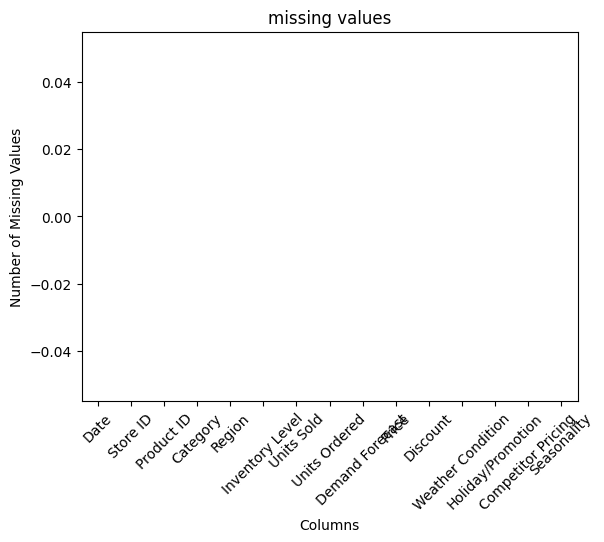

In [ ]:
missing_counts = df.isnull().sum()
sns.barplot(x=missing_counts.index, y=missing_counts.values, palette='viridis')
plt.title("missing values")
plt.ylabel('Number of Missing Values')
plt.xlabel('Columns')
plt.xticks(rotation=45)
plt.show()

## **Check and Remove Outliers**

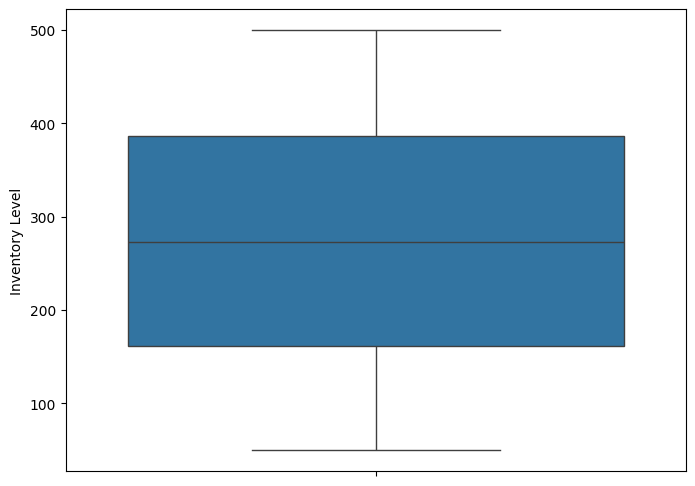

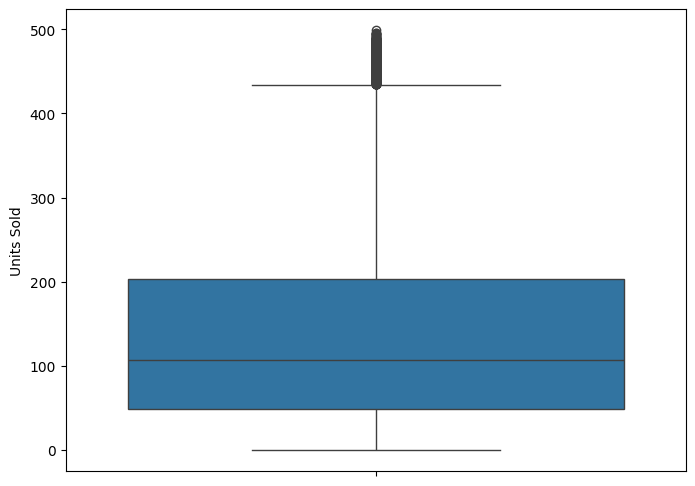

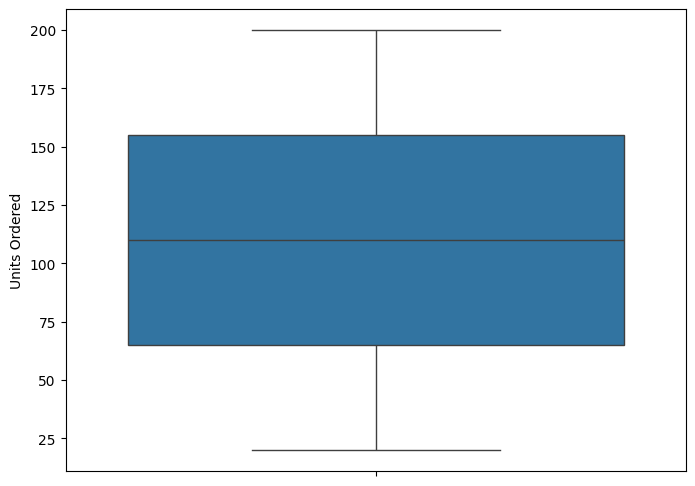

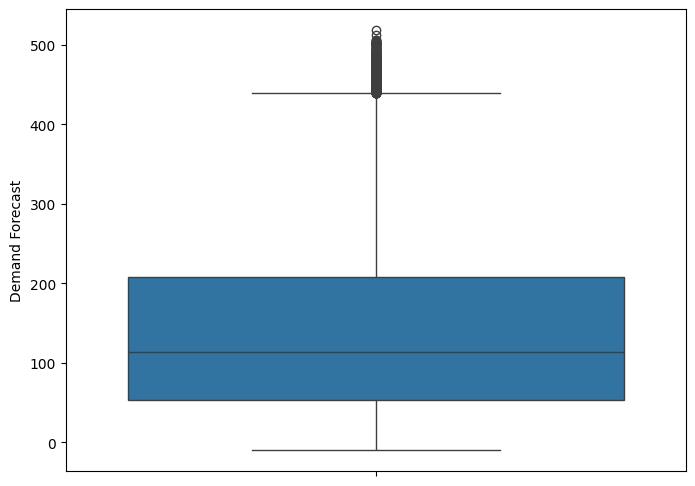

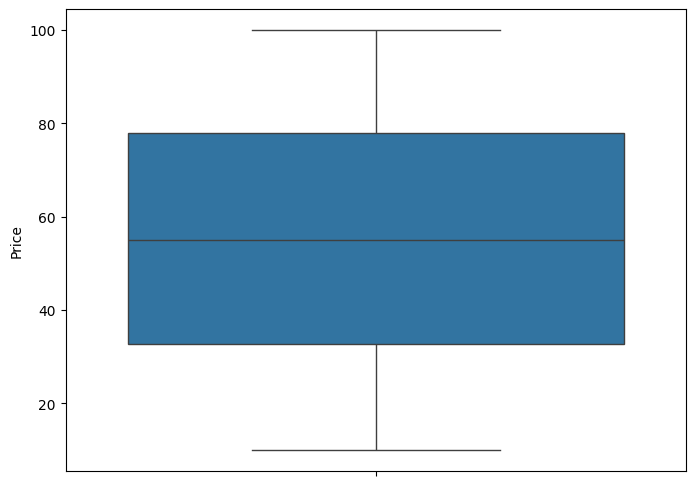

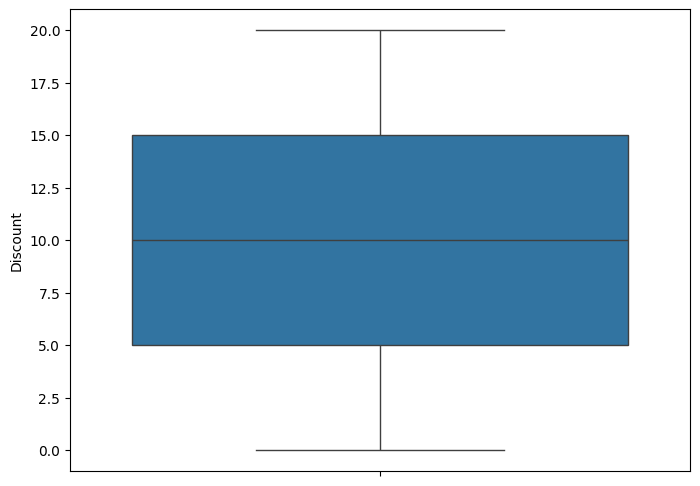

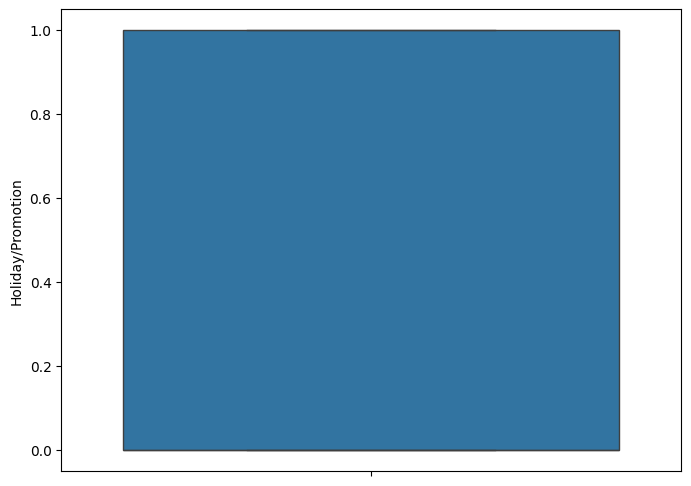

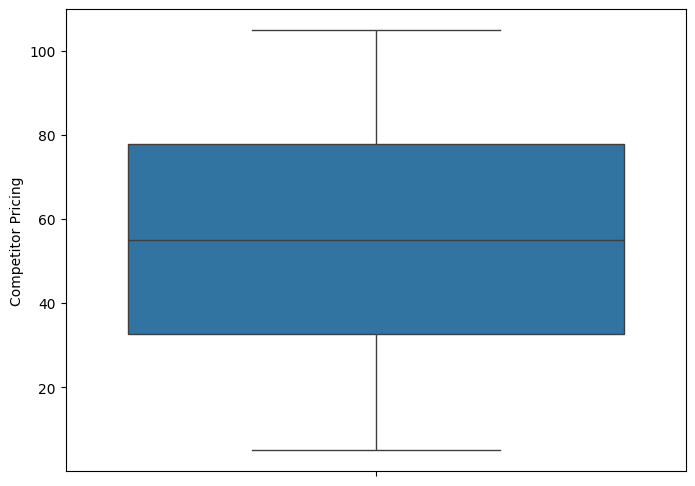

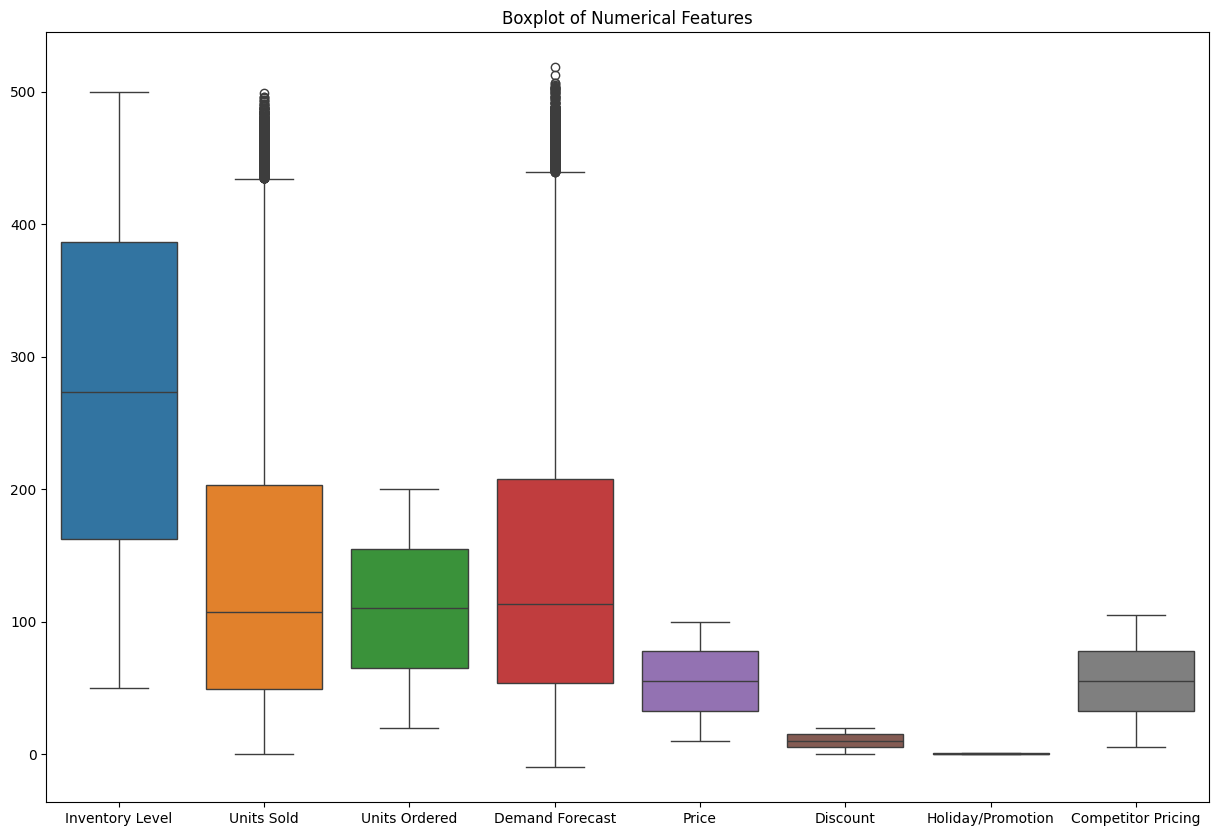

In [ ]:
for column in df.select_dtypes(include=['int64','float64']).columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(df[column])
    plt.show()

plt.figure(figsize=(15, 10))
sns.boxplot(data=df.select_dtypes(include=['int64','float64']))
plt.title('Boxplot of Numerical Features')
plt.show()

         Date Store ID Product ID     Category Region  Inventory Level  \
0  2022-01-01     S001      P0001    Groceries  North              231   
1  2022-01-01     S001      P0002         Toys  South              204   
2  2022-01-01     S001      P0003         Toys   West              102   
3  2022-01-01     S001      P0004         Toys  North              469   
4  2022-01-01     S001      P0005  Electronics   East              166   

   Units Sold  Units Ordered  Demand Forecast  Price  Discount  \
0         127             55           135.47  33.50        20   
1         150             66           144.04  63.01        20   
2          65             51            74.02  27.99        10   
3          61            164            62.18  32.72        10   
4          14            135             9.26  73.64         0   

  Weather Condition  Holiday/Promotion  Competitor Pricing Seasonality  
0             Rainy                  0               29.69      Autumn  
1           

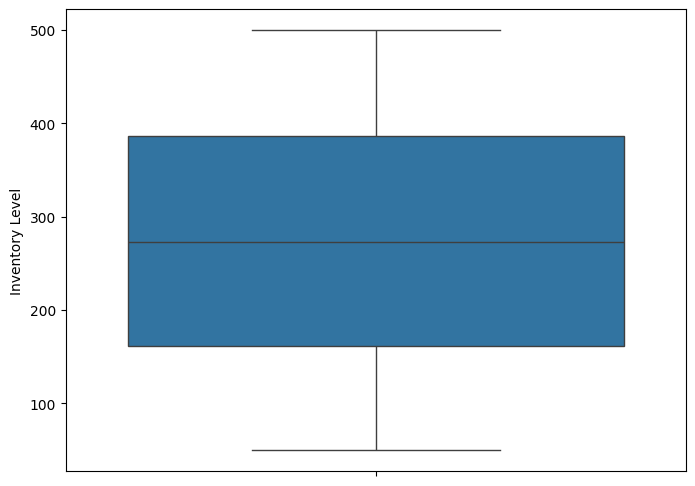

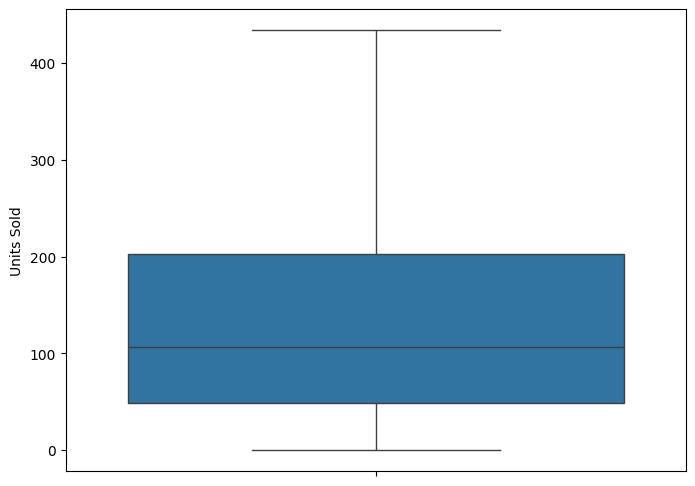

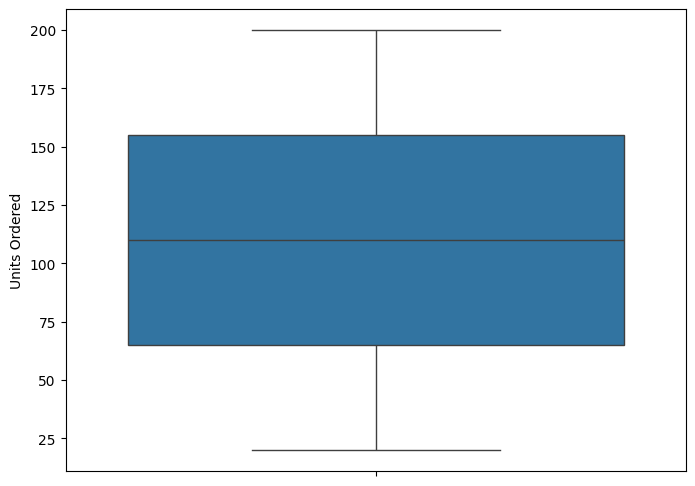

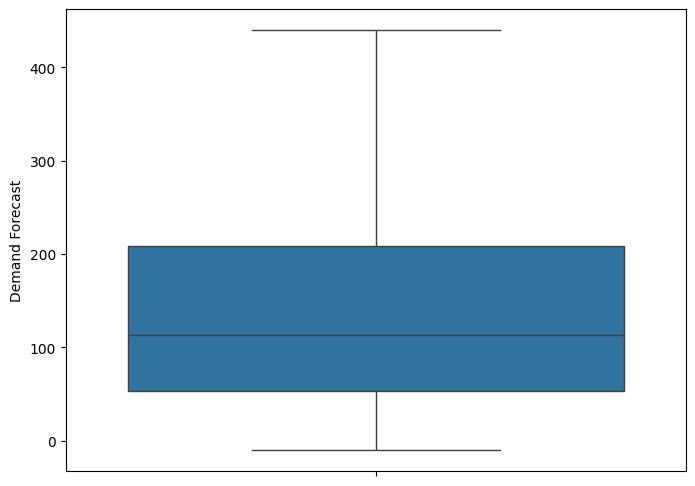

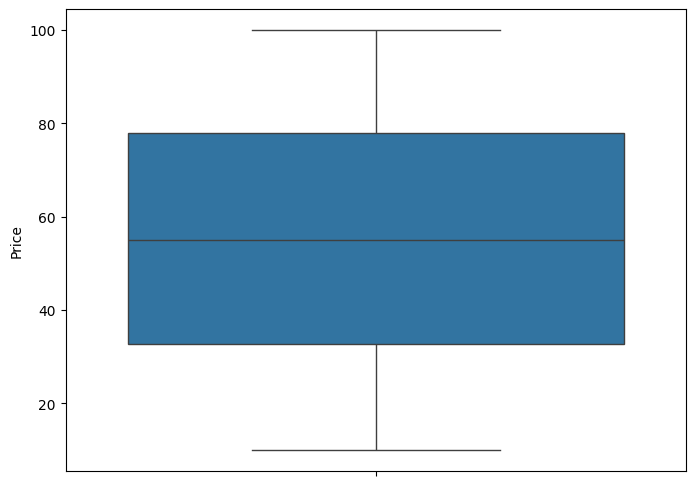

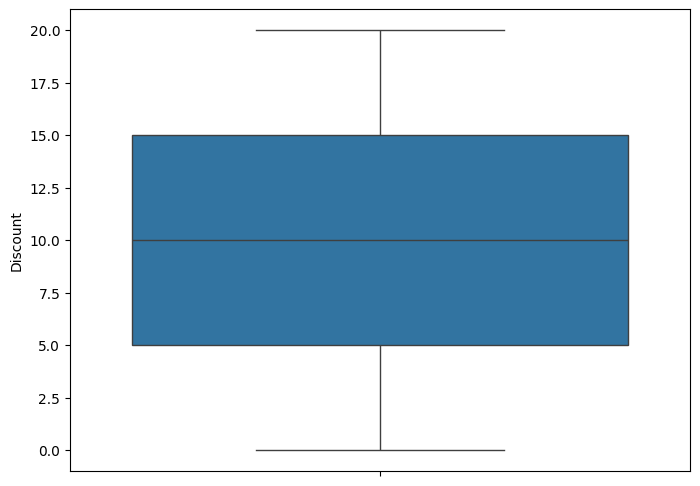

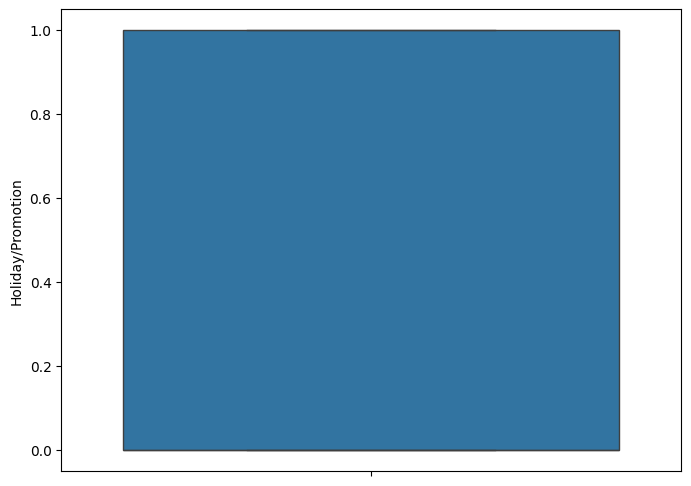

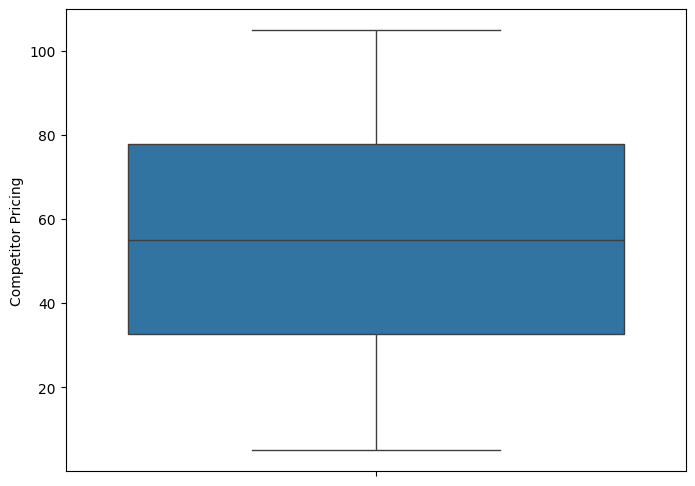

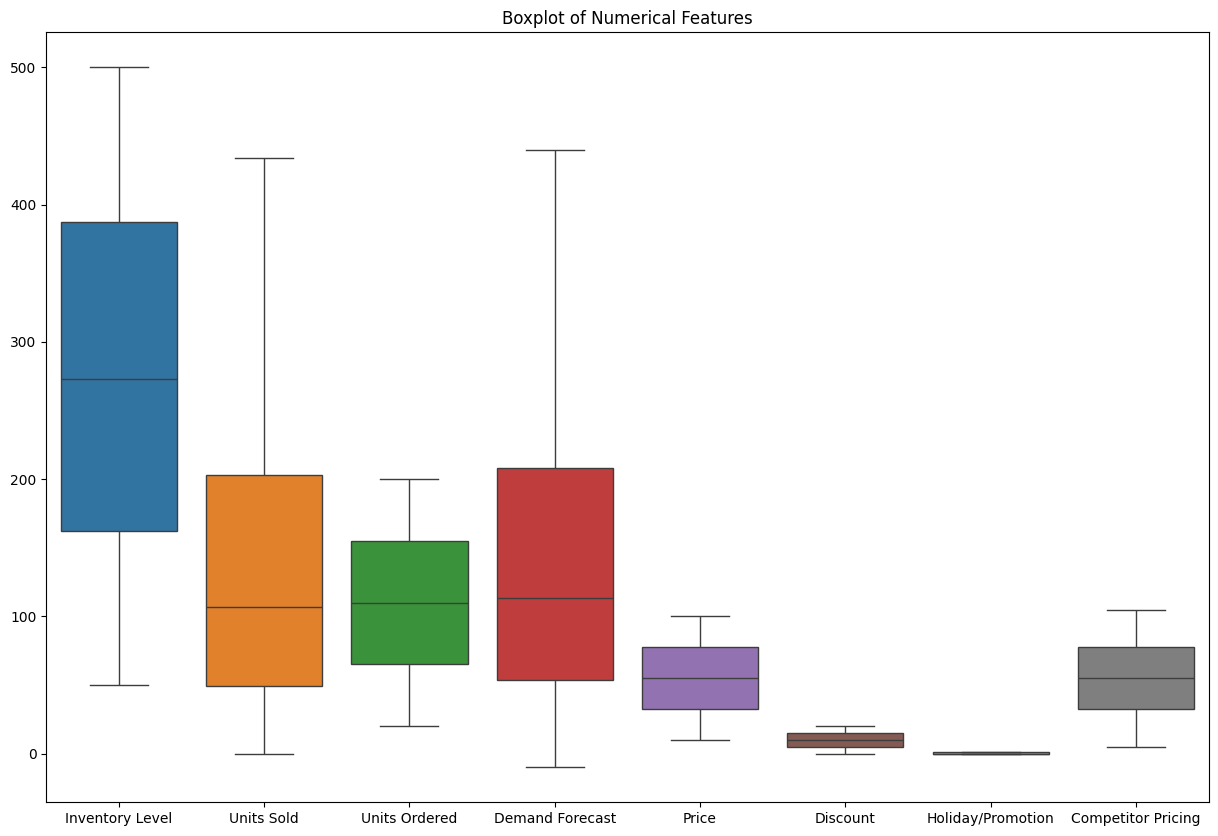

In [ ]:
# Function to cap outliers using IQR (Interquartile Range)
def cap_outliers(df, columns):
    for col in columns:
        # Calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        # Define the lower and upper bounds for acceptable values
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Cap values outside the bounds to the lower or upper threshold
        df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

    return df

# List of columns from which to cap outliers
columns_to_cap_outliers = ['Units Sold', 'Demand Forecast']

# Assuming df_rename is your original DataFrame, apply the cap_outliers function
df_capped = cap_outliers(df, columns_to_cap_outliers)

# Display the first few rows of the capped DataFrame
print(df_capped.head())

# Generate individual boxplots for each column after capping outliers
for column in df_capped.select_dtypes(include=['int64','float64']).columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(df_capped[column])
    plt.show()

# Generate a combined boxplot for all selected columns after capping outliers
plt.figure(figsize=(15, 10))
sns.boxplot(data=df_capped.select_dtypes(include=['int64','float64']))
plt.title('Boxplot of Numerical Features')
plt.show()


**Making a copy for Challange 3**

In [ ]:
# making a copy for challange 3 to work later
df_capped_2 = df_capped.copy()

# **Hypothesis Testing**

## **Hypothesis-1**
#### Null Hypothesis (H₀): There is no significant correlation between Inventory Level and Units Sold.
#### Alternative Hypothesis (H₁): There is a significant correlation between Inventory Level and Units Sold.
Method : Pearson Correlation

## **Hypothesis-2**
#### H₀: Demand Forecast does not significantly differ across different regions.
#### H₁: Demand Forecast significantly differs across different regions.
Method : One Way ANOVA test

## **Hypothesis-3**
#### H₀: The effect of Competitor Pricing on Units Sold does not vary across Regions.
#### H₁: The effect of Competitor Pricing on Units Sold varies across Regions.
Method : Two Way ANOVA

## **Hypothesis-4**
#### H₀: The accuracy of Demand Forecast does not improve over time.
#### H₁: The accuracy of Demand Forecast improves over time.
Method : Mean Absolute Error (MAE)

## **Hypothesis-5**
#### H₀: Sales variance is equal across different Stores.
#### H₁: Sales variance differs significantly across Stores.
Method : Levene’s Test

## **Hypothesis-1 (Pearson Correlation)**
H₀ : There is no significant correlation between Inventory Level and Units Sold.

H₁ : There is a significant correlation between Inventory Level and Units Sold.


In [ ]:
!pip install scipy
import scipy.stats as stats

# Select the two columns
inventory = df_capped["Inventory Level"]
units_sold = df_capped["Units Sold"]

# Perform Pearson correlation test
correlation, p_value = stats.pearsonr(inventory, units_sold)

# Print results
print(f"Pearson Correlation Coefficient: {correlation}")
print(f"P-value: {p_value}")

# Interpretation
if p_value < 0.05:
    print("Reject H₀: Significant correlation exists.")
else:
    print("Fail to reject H₀: No significant correlation.")

Pearson Correlation Coefficient: 0.5901899467262202
P-value: 0.0
Reject H₀: Significant correlation exists.


## **Hypothesis-2 (ANOVA test)**
H₀: Demand Forecast does not significantly differ across different regions.

H₁: Demand Forecast significantly differs across different regions.


In [ ]:
from scipy.stats import f_oneway

# Group Demand Forecast by Region
regions = df_capped["Region"].unique()  # Get all unique regions
demand_forecast_groups = [df_capped[df_capped["Region"] == region]["Demand Forecast"] for region in regions]

# Perform ANOVA Test
f_stat, p_value = f_oneway(*demand_forecast_groups)

# Print results
print(f"F-Statistic: {f_stat}")
print(f"P-value: {p_value}")

# Interpretation
alpha = 0.05  # Significance level
if p_value < alpha:
    print("Reject H₀: Demand Forecast significantly differs across different regions.")
else:
    print("Fail to reject H₀: No significant difference in Demand Forecast across regions.")

F-Statistic: 0.6014816277995594
P-value: 0.6139703158996084
Fail to reject H₀: No significant difference in Demand Forecast across regions.


## **Hypothesis-3 (Two Way ANOVA)**
H₀: The effect of Competitor Pricing on Units Sold does not vary across Regions.

H₁: The effect of Competitor Pricing on Units Sold varies across Regions.

In [ ]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

df_capped.columns = df_capped.columns.str.replace(' ', '_')

# Define the dependent and independent variables
dependent_var = 'Units_Sold'  # Replace with your dependent variable column name
factor1 = 'Region'    # Replace with your first factor column name
factor2 = 'Competitor_Pricing'  # Replace with your second factor column name

# # Ensure the factors are treated as categorical variables
df_capped.tail(1000)[factor1] = df_capped[factor1].astype('category')
# df_capped[factor2] = df_capped[factor2].astype('category')  # Use 'category' instead of 'object'

# Construct the Two-Way ANOVA formula dynamically
formula = f'{dependent_var} ~ C({factor1}) + C({factor2}) + C({factor1}):C({factor2})'

# Fit the model
model = smf.ols(formula, data=df_capped.tail(1000)).fit()

# Perform ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)
# Print ANOVA table
print(anova_table)

# Get the p-value for the interaction effect (Region × Competitor Pricing)
interaction_p_value = anova_table.loc[f"C({factor1}):C({factor2})", "PR(>F)"]

# Interpretation
alpha = 0.05  # Significance level
if interaction_p_value < alpha:
    print("Reject H₀: Competitor Pricing affects Units Sold differently across Regions.")
else:
    print("Fail to reject H₀: No significant difference in how Competitor Pricing affects Units Sold across Regions.")

print(interaction_p_value)
df_capped.columns = df_capped.columns.str.replace('_', ' ')

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

                                       sum_sq      df         F    PR(>F)
C(Region)                        1.542065e+02     3.0  0.002172  0.963667
C(Competitor_Pricing)            1.479583e+07   959.0  0.651804  0.872716
C(Region):C(Competitor_Pricing)  2.876685e+07  2877.0  0.422425  0.992950
Residual                         2.603730e+05    11.0       NaN       NaN
Fail to reject H₀: No significant difference in how Competitor Pricing affects Units Sold across Regions.
0.9929497947058508


covariance of constraints does not have full rank. The number of constraints is 2877, but rank is 768


## **Hypothesis-4 (MAE)**
H₀: The accuracy of Demand Forecast does not improve over time.

H₁: The accuracy of Demand Forecast improves over time.


In [ ]:
from sklearn.metrics import mean_absolute_error

# Sort data by Date
df_capped["Date"] = pd.to_datetime(df_capped["Date"])
df_capped = df_capped.sort_values("Date")

# Calculate MAE for the first and last 6 months
first_half = df_capped[df_capped["Date"] < df_capped["Date"].median()]
second_half = df_capped[df_capped["Date"] >= df_capped["Date"].median()]

mae_first = mean_absolute_error(first_half["Units Sold"], first_half["Demand Forecast"])
mae_second = mean_absolute_error(second_half["Units Sold"], second_half["Demand Forecast"])

# Print results
print(f"MAE (First Half): {mae_first}")
print(f"MAE (Second Half): {mae_second}")

# Interpretation
if mae_second < mae_first:
    print("Reject H₀: Forecast accuracy has improved over time.")
else:
    print("Fail to reject H₀: No significant improvement in forecast accuracy.")


MAE (First Half): 8.289878150684931
MAE (Second Half): 8.322941325136613
Fail to reject H₀: No significant improvement in forecast accuracy.


## **Hypothesis-5 ( Levene’s Test)**
H₀: Sales variance is equal across different Stores.

H₁: Sales variance differs significantly across Stores.


In [ ]:
from scipy.stats import levene

# Group sales data by store
stores = df_capped.groupby("Store ID")["Units Sold"].apply(list)

# Perform Levene’s test
stat, p_value = levene(*stores)

# Print results
print(f"Levene’s Test Statistic: {stat}")
print(f"P-value: {p_value}")

# Interpretation
if p_value < 0.05:
    print("Reject H₀: Sales variance differs significantly across Stores.")
else:
    print("Fail to reject H₀: Sales variance is equal across Stores.")


Levene’s Test Statistic: 1.6337800926686756
P-value: 0.16260354213686695
Fail to reject H₀: Sales variance is equal across Stores.


In [ ]:
df_capped.head(30)

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
72,2022-01-01,S004,P0013,Furniture,East,191,56,65,54.47,61.81,0,Sunny,0,63.92,Autumn
71,2022-01-01,S004,P0012,Electronics,North,349,9,165,0.95,14.25,5,Rainy,1,18.56,Spring
70,2022-01-01,S004,P0011,Electronics,West,205,46,27,46.65,54.84,0,Sunny,1,57.76,Spring
69,2022-01-01,S004,P0010,Groceries,East,447,104,96,115.03,33.48,15,Cloudy,0,37.15,Summer
68,2022-01-01,S004,P0009,Furniture,North,63,40,73,51.78,59.23,10,Rainy,1,61.10,Summer
67,2022-01-01,S004,P0008,Furniture,South,250,51,137,54.98,85.88,20,Snowy,1,86.14,Winter
66,2022-01-01,S004,P0007,Electronics,West,264,190,139,197.45,67.26,20,Cloudy,0,64.78,Summer
65,2022-01-01,S004,P0006,Electronics,East,470,382,195,396.40,41.35,10,Snowy,0,39.86,Summer
64,2022-01-01,S004,P0005,Groceries,North,397,200,172,196.57,81.72,0,Snowy,1,85.22,Spring


# **Challange 1. Time Series Demand Forecasting**

1.  Feature Engineering
2.  Null values Fillup, Outliers Removal
3.  Scaling the numerical values
4.  Label Encoding Categorical values
5.  Train Test Split
6.  Model Train

*    ARIMA
*    XGBoost
*    LSTM

7.  HyperParameter Tuning
8.  X-AI

*   SHAP
*   LIME




## 1. Feature Engineering

In [ ]:
!pip install shap lime prophet

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

In [ ]:
# Convert Date column to datetime format & sort by time
df_capped["Date"] = pd.to_datetime(df_capped["Date"])
df = df_capped.sort_values(by=["Store ID", "Product ID", "Date"])

# ------------------ Step 2: Feature Engineering ------------------

# Time-based features
df["day_of_week"] = df["Date"].dt.dayofweek
df["month"] = df["Date"].dt.month
df["week_of_year"] = df["Date"].dt.isocalendar().week.astype(int)
df["is_weekend"] = df["day_of_week"].apply(lambda x: 1 if x >= 5 else 0)

# Lag Features (Past Sales Data)
df["sales_lag_1"] = df.groupby(["Store ID", "Product ID"])["Units Sold"].shift(1)
df["sales_lag_7"] = df.groupby(["Store ID", "Product ID"])["Units Sold"].shift(7)
df["sales_lag_30"] = df.groupby(["Store ID", "Product ID"])["Units Sold"].shift(30)

# Rolling Window Features (Trends)
df["sales_ma_7"] = df.groupby(["Store ID", "Product ID"])["Units Sold"].transform(lambda x: x.rolling(7).mean())
df["sales_ma_30"] = df.groupby(["Store ID", "Product ID"])["Units Sold"].transform(lambda x: x.rolling(30).mean())
df["sales_rolling_std_7"] = df.groupby(["Store ID", "Product ID"])["Units Sold"].transform(lambda x: x.rolling(7).std())
df["sales_rolling_std_30"] = df.groupby(["Store ID", "Product ID"])["Units Sold"].transform(lambda x: x.rolling(30).std())

# External Features
df["discount_percentage"] = df["Discount"] / df["Price"]
df["competitor_price_diff"] = df["Competitor Pricing"] - df["Price"]


df["sales_lag_1"].fillna(0, inplace=True)
df["sales_lag_7"].fillna(0, inplace=True)
df["sales_lag_30"].fillna(0, inplace=True)

df["sales_ma_7"].fillna(0, inplace=True)
df["sales_ma_30"].fillna(0, inplace=True)
df["sales_rolling_std_7"].fillna(0, inplace=True)
df["sales_rolling_std_30"].fillna(0, inplace=True)

df["discount_percentage"] = np.where(df["Price"] == 0, 0, df["Discount"] / df["Price"])



A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


A valu

In [ ]:
df.head(30)

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,...,is_weekend,sales_lag_1,sales_lag_7,sales_lag_30,sales_ma_7,sales_ma_30,sales_rolling_std_7,sales_rolling_std_30,discount_percentage,competitor_price_diff
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,...,1,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.597015,-3.81
100,2022-01-02,S001,P0001,Groceries,West,116,81,104,92.94,27.95,...,1,127.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.357782,2.94
200,2022-01-03,S001,P0001,Electronics,West,154,5,189,5.36,62.70,...,0,81.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.318979,-4.48
300,2022-01-04,S001,P0001,Groceries,South,85,58,193,52.87,77.88,...,0,5.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.192604,-1.89
400,2022-01-05,S001,P0001,Groceries,South,238,147,37,150.27,28.46,...,0,58.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.702741,0.94
500,2022-01-06,S001,P0001,Electronics,East,198,37,155,39.09,91.05,...,0,147.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.054915,-3.75
600,2022-01-07,S001,P0001,Furniture,North,195,107,106,117.92,53.99,...,0,37.0,0.0,0.0,80.285714,0.000000,50.638307,0.000000,0.185219,4.81
700,2022-01-08,S001,P0001,Furniture,East,231,2,119,0.84,66.30,...,1,107.0,127.0,0.0,62.428571,0.000000,53.384945,0.000000,0.301659,-2.48
800,2022-01-09,S001,P0001,Electronics,South,373,350,178,352.24,41.72,...,1,2.0,81.0,0.0,100.857143,0.000000,121.870736,0.000000,0.000000,-3.04
900,2022-01-10,S001,P0001,Electronics,West,327,36,132,39.50,32.68,...,0,350.0,5.0,0.0,105.285714,0.000000,118.318376,0.000000,0.152999,2.03


## 2. Null values Fillup, Outliers Removal


*   Finding Missing Values
*   Filling the missing values
*   Detect Outliers
*   Remove Outliers



In [ ]:
missing_values = df.isna().sum()
missing_values_percent = 100 * df.isna().sum()/len(df)
print(missing_values_percent)
print(missing_values)

Date                     0.0
Store ID                 0.0
Product ID               0.0
Category                 0.0
Region                   0.0
Inventory Level          0.0
Units Sold               0.0
Units Ordered            0.0
Demand Forecast          0.0
Price                    0.0
Discount                 0.0
Weather Condition        0.0
Holiday/Promotion        0.0
Competitor Pricing       0.0
Seasonality              0.0
day_of_week              0.0
month                    0.0
week_of_year             0.0
is_weekend               0.0
sales_lag_1              0.0
sales_lag_7              0.0
sales_lag_30             0.0
sales_ma_7               0.0
sales_ma_30              0.0
sales_rolling_std_7      0.0
sales_rolling_std_30     0.0
discount_percentage      0.0
competitor_price_diff    0.0
dtype: float64
Date                     0
Store ID                 0
Product ID               0
Category                 0
Region                   0
Inventory Level          0
Units Sold 

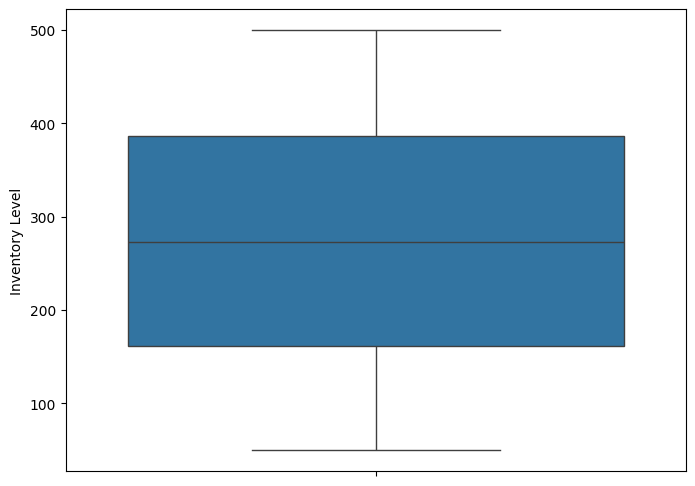

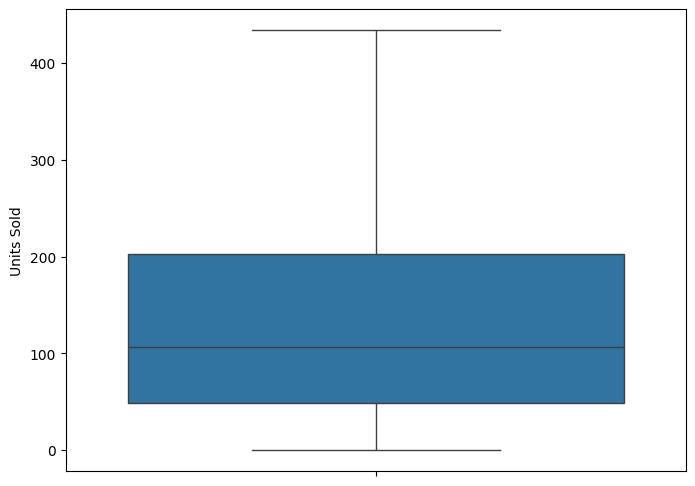

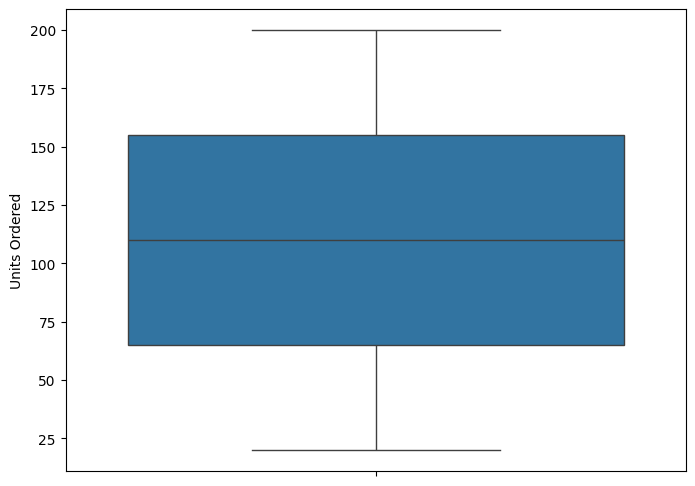

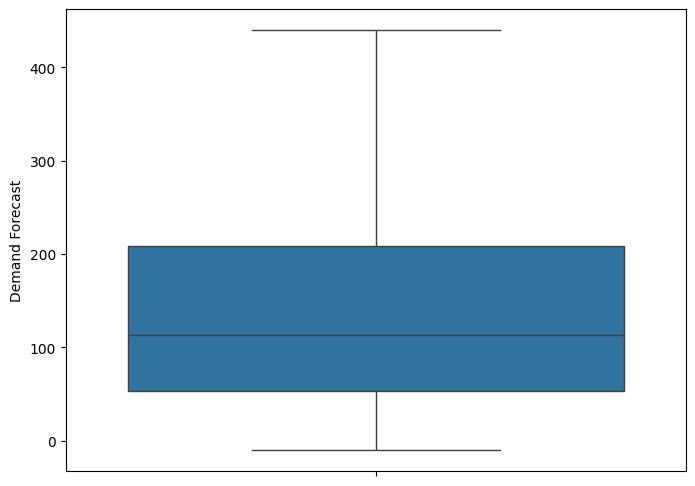

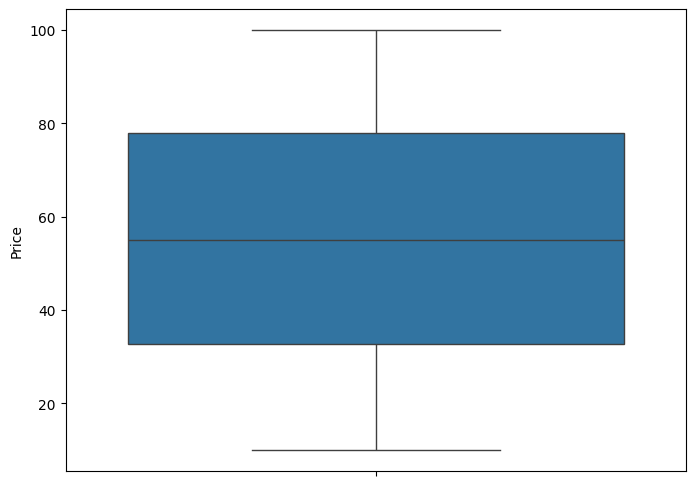

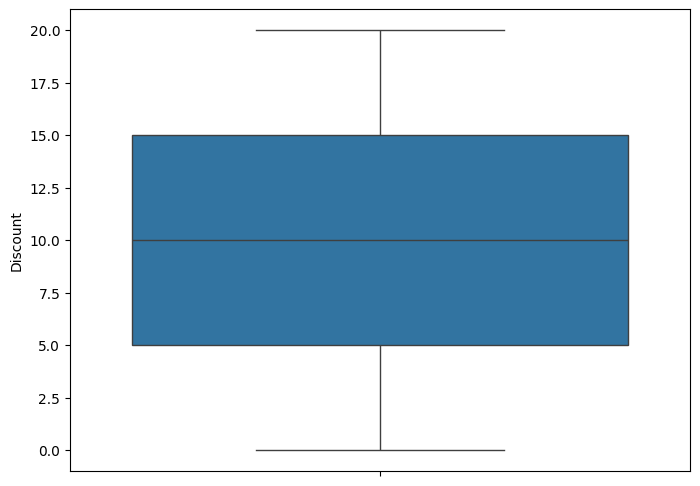

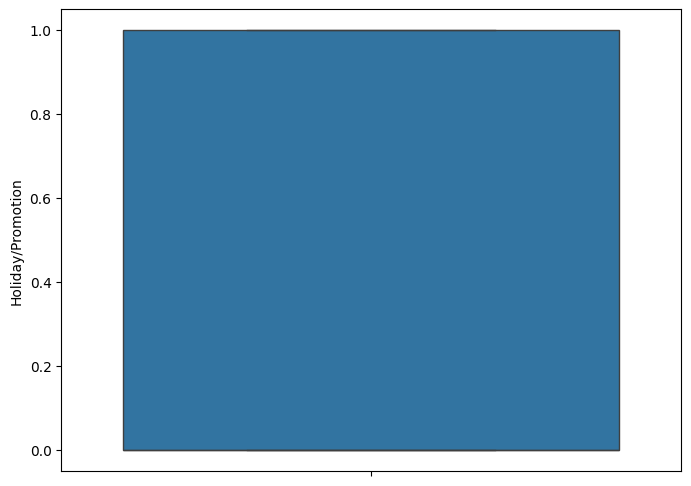

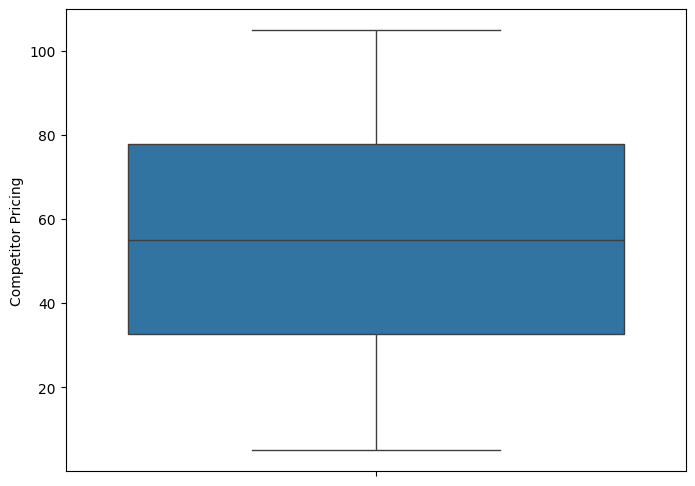

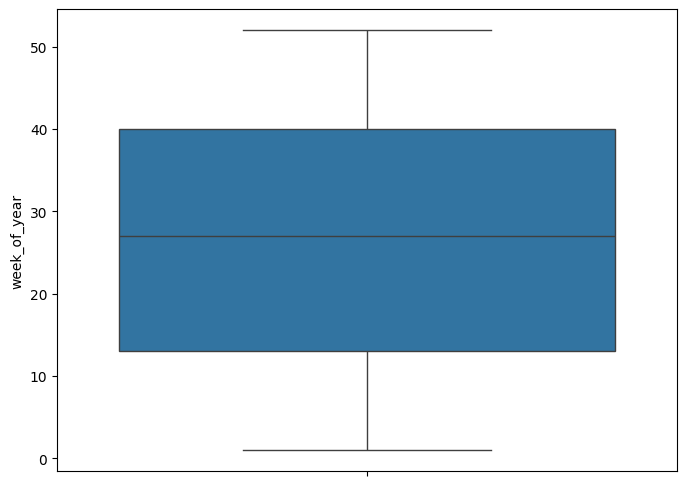

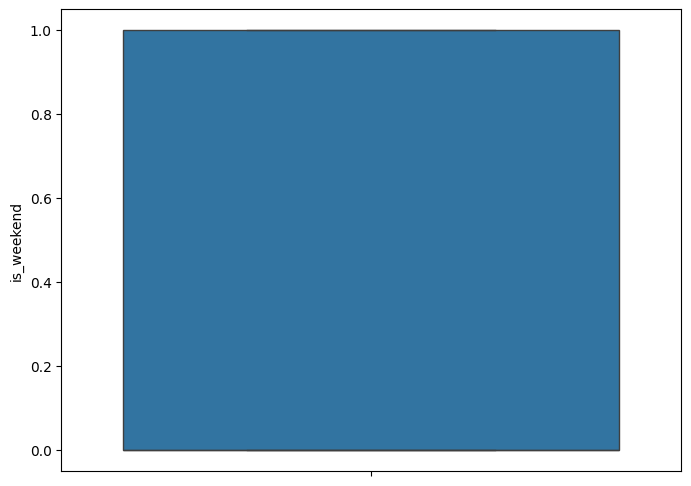

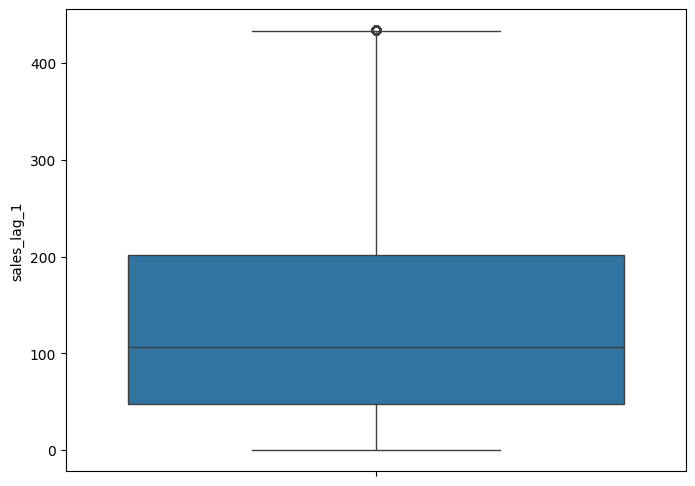

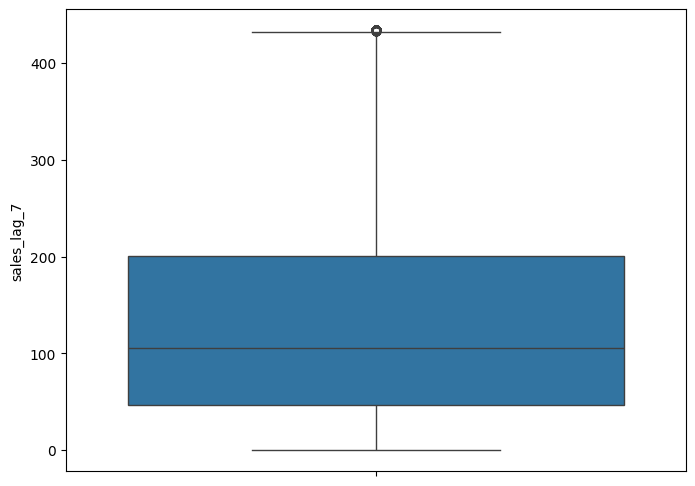

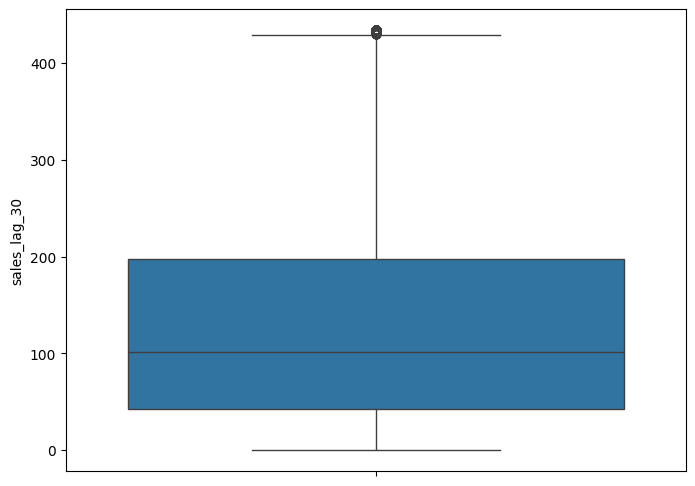

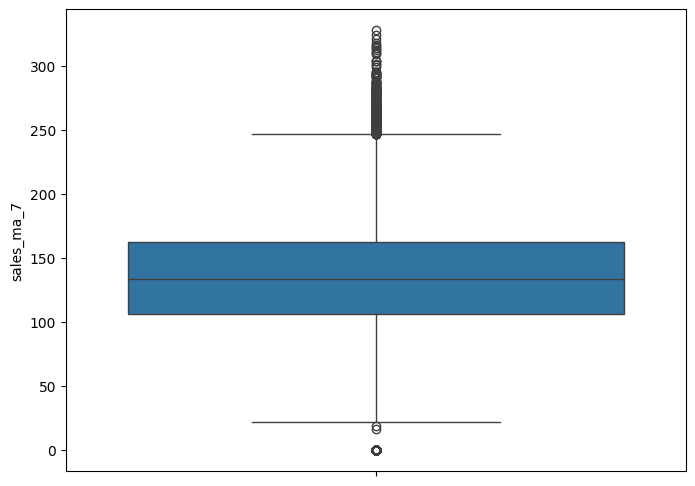

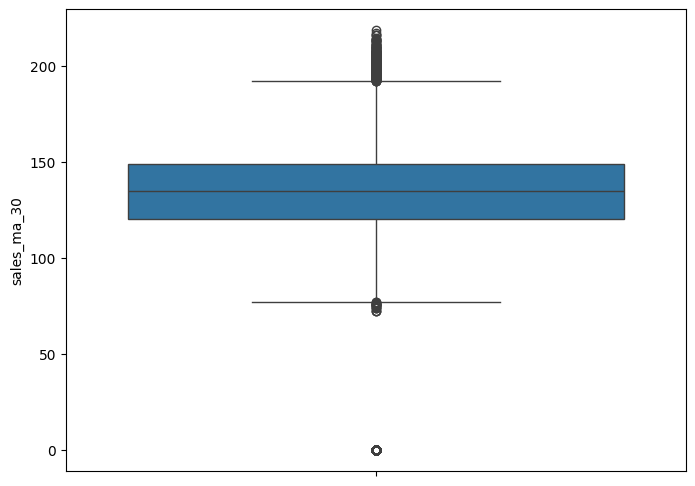

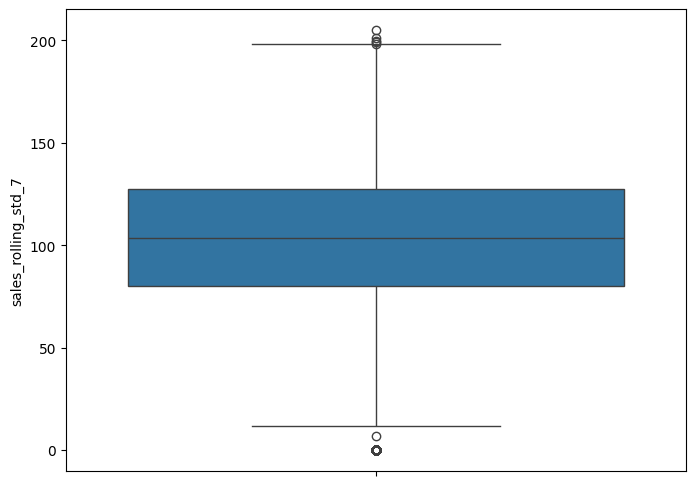

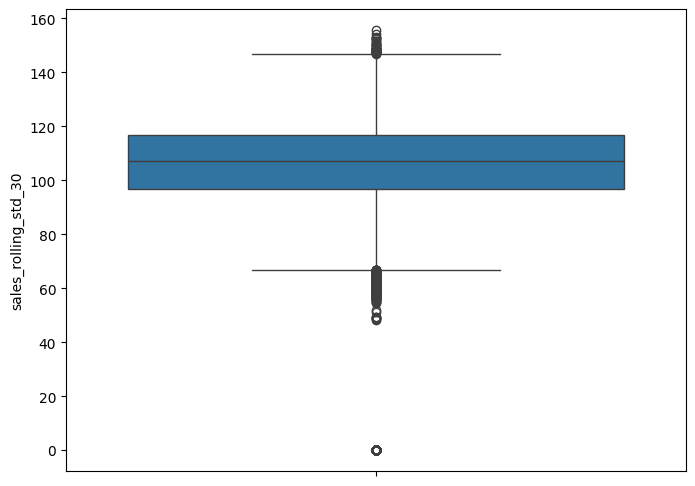

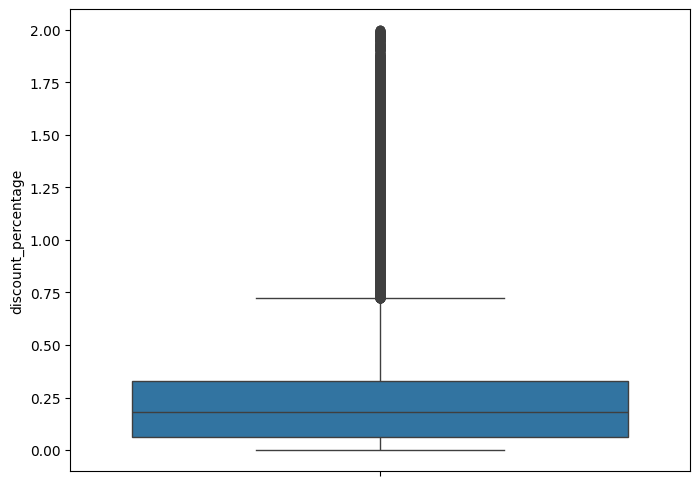

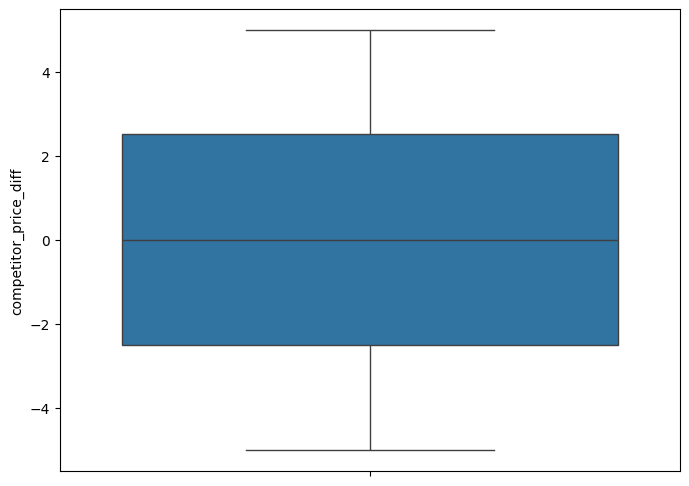

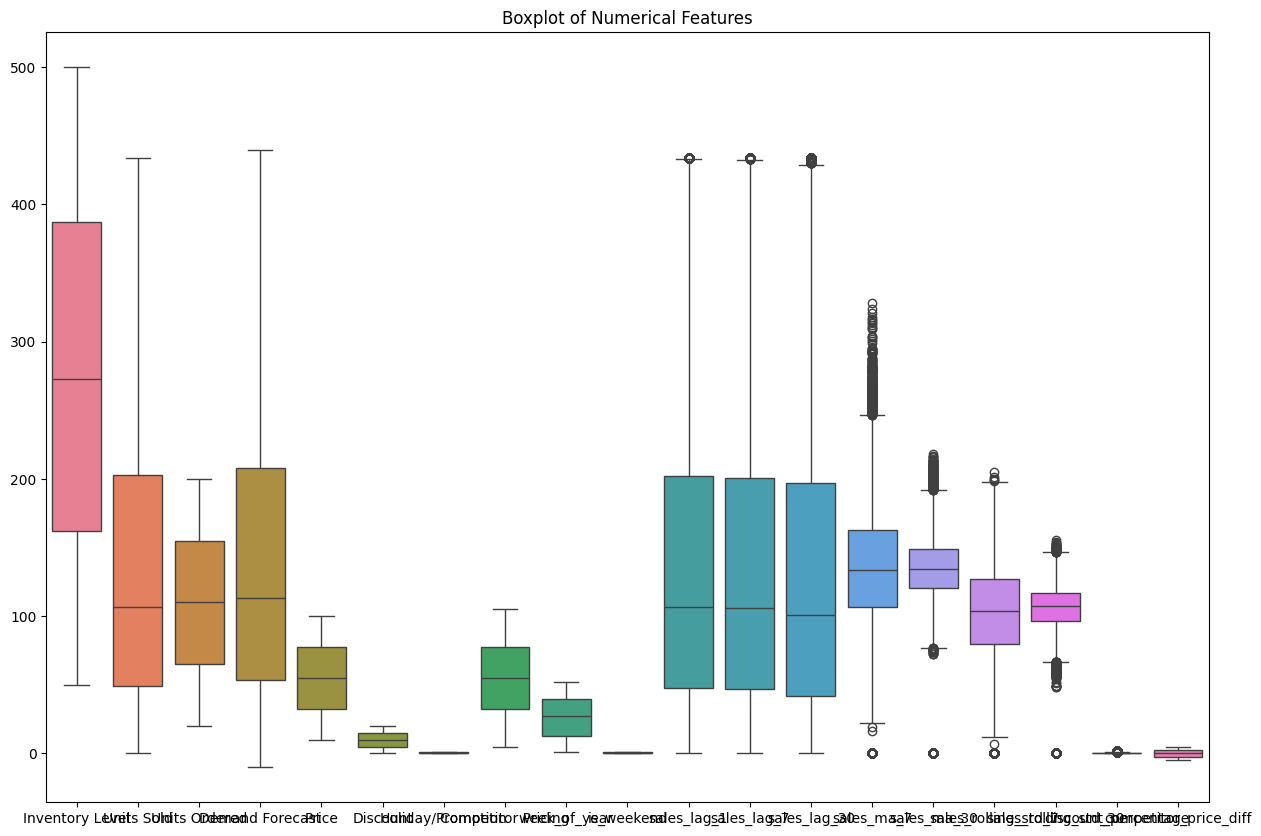

In [ ]:
for column in df.select_dtypes(include=['int64','float64']).columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(df[column])
    plt.show()

plt.figure(figsize=(15, 10))
sns.boxplot(data=df.select_dtypes(include=['int64','float64']))
plt.title('Boxplot of Numerical Features')
plt.show()

          Date Store ID Product ID     Category Region  Inventory Level  \
0   2022-01-01     S001      P0001    Groceries  North              231   
100 2022-01-02     S001      P0001    Groceries   West              116   
200 2022-01-03     S001      P0001  Electronics   West              154   
300 2022-01-04     S001      P0001    Groceries  South               85   
400 2022-01-05     S001      P0001    Groceries  South              238   

     Units Sold  Units Ordered  Demand Forecast  Price  ...  is_weekend  \
0           127             55           135.47  33.50  ...           1   
100          81            104            92.94  27.95  ...           1   
200           5            189             5.36  62.70  ...           0   
300          58            193            52.87  77.88  ...           0   
400         147             37           150.27  28.46  ...           0   

    sales_lag_1  sales_lag_7  sales_lag_30 sales_ma_7  sales_ma_30  \
0           0.0          0.0

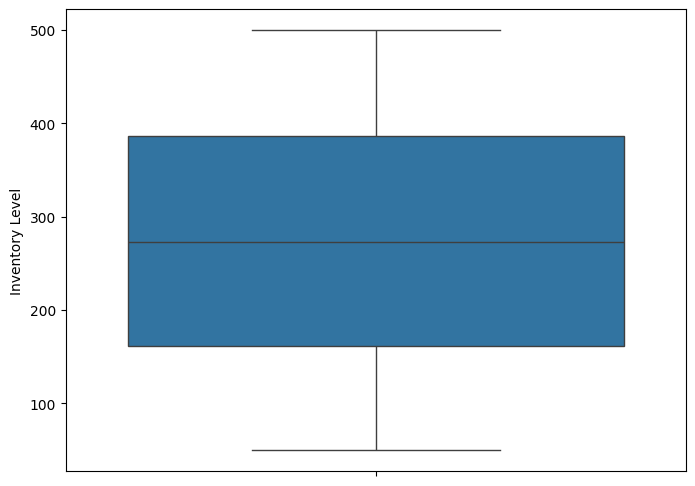

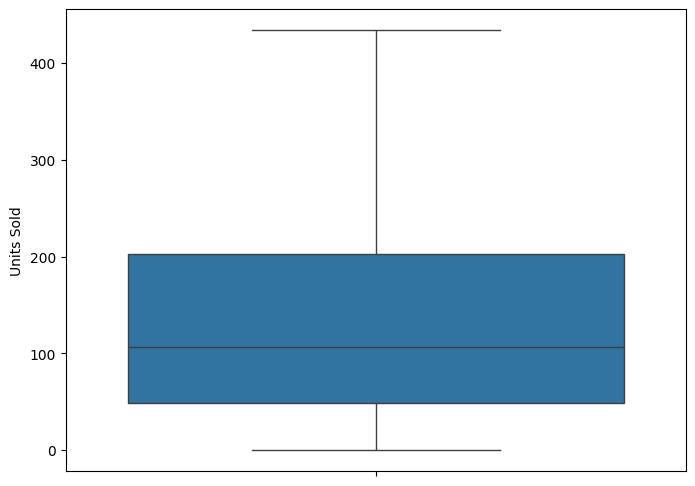

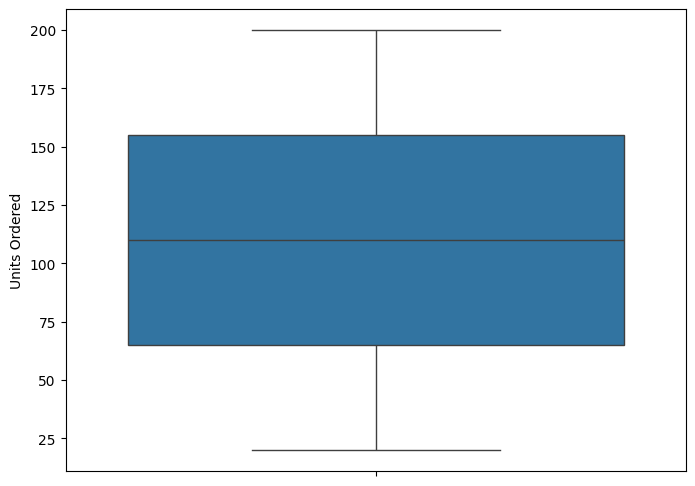

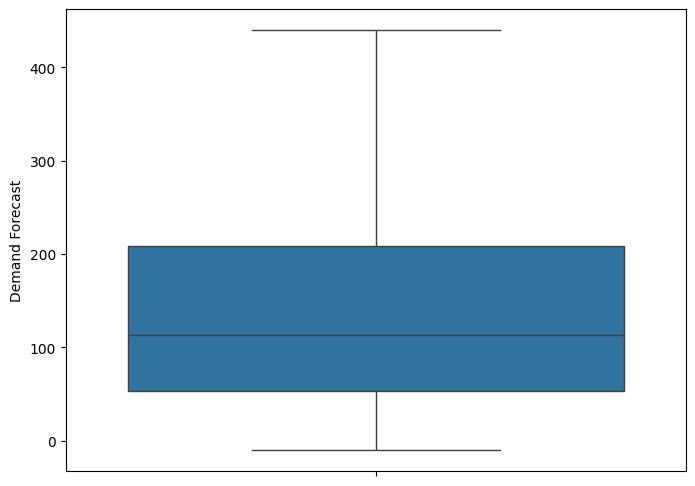

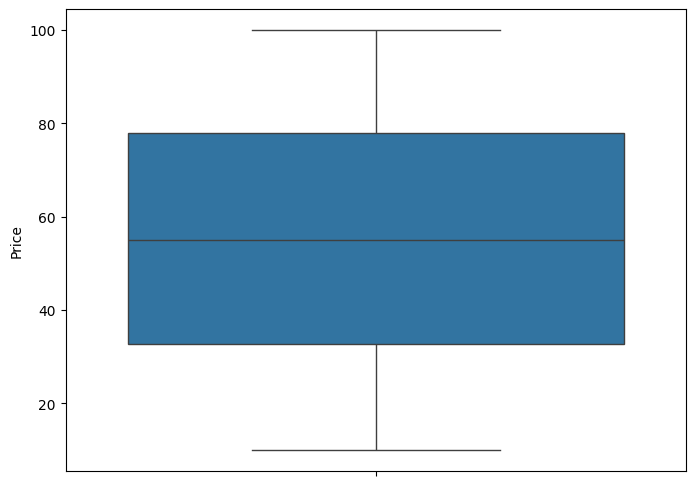

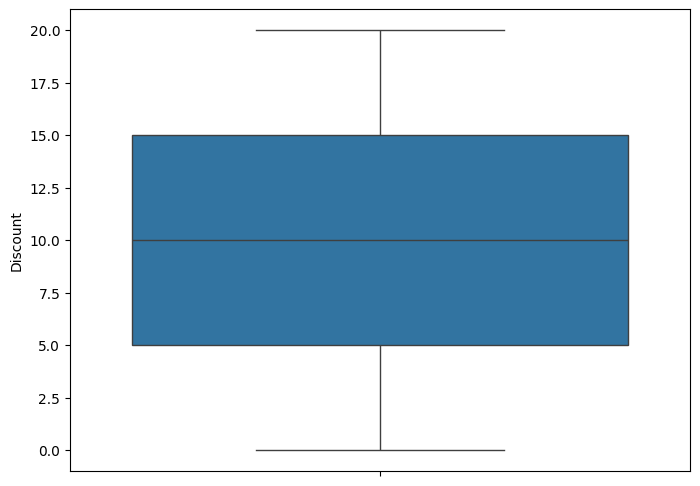

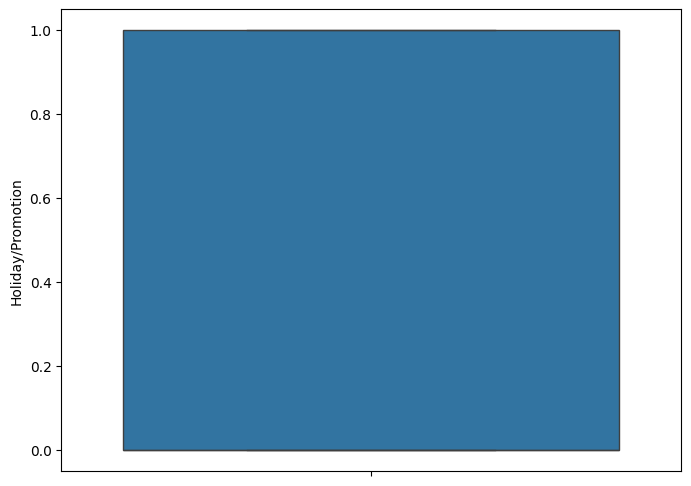

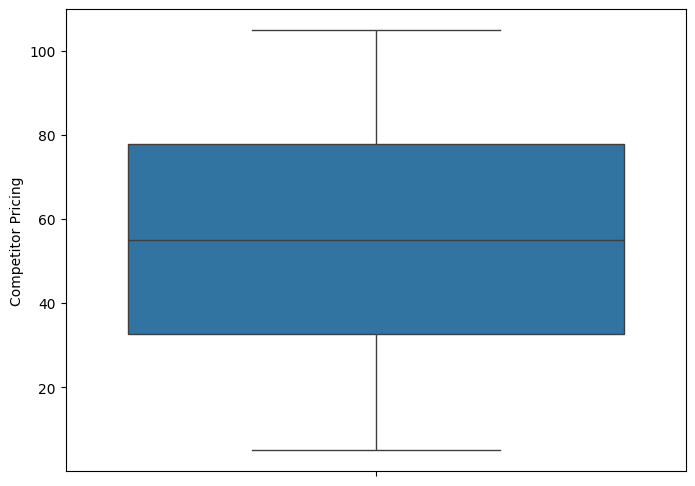

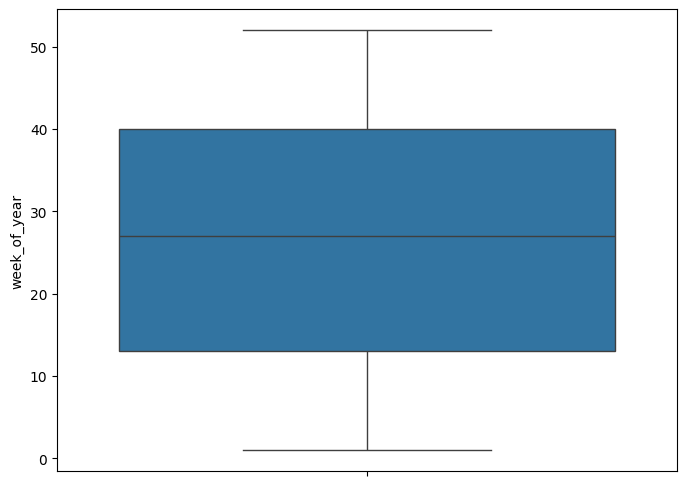

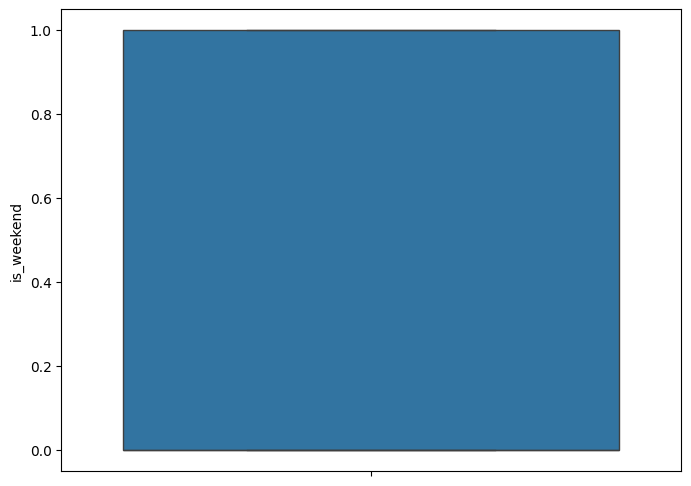

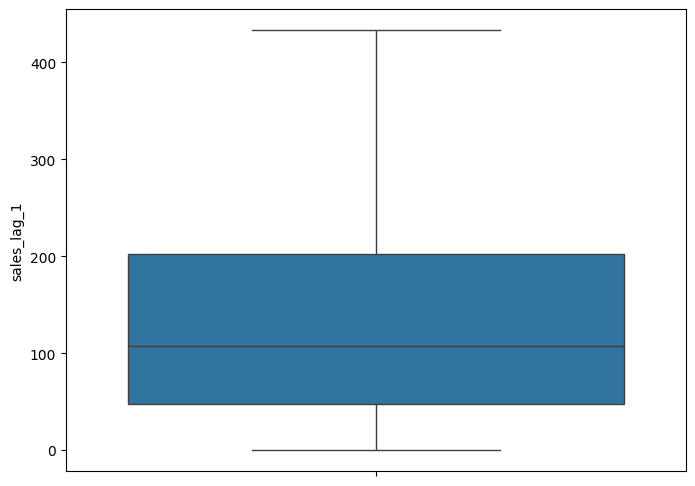

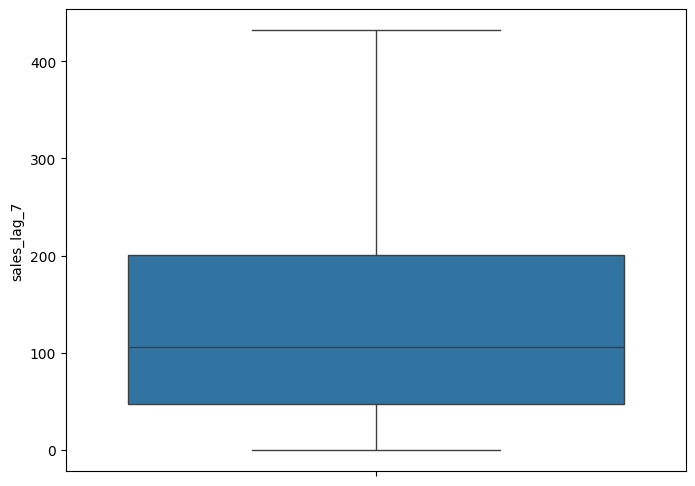

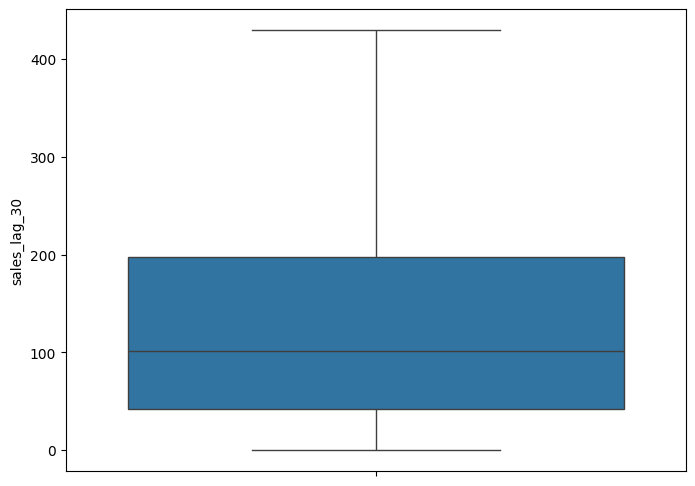

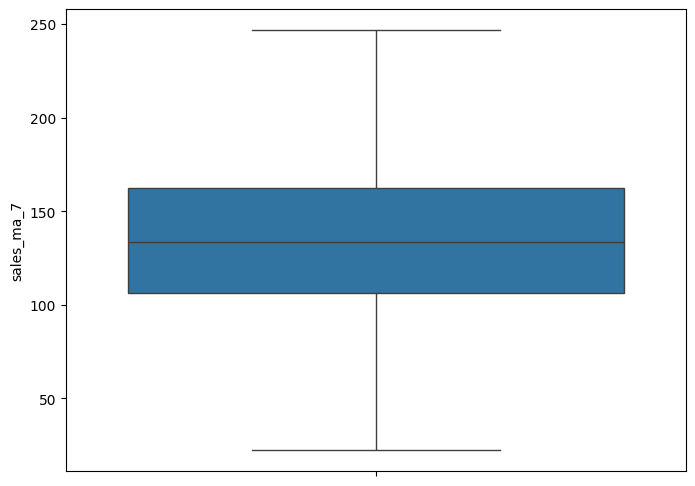

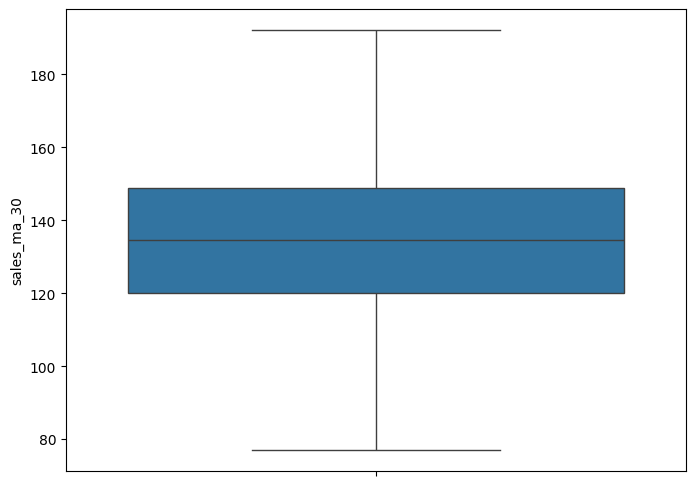

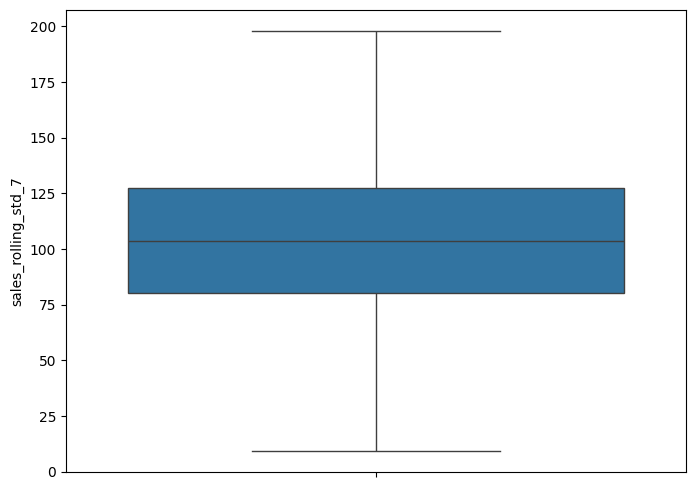

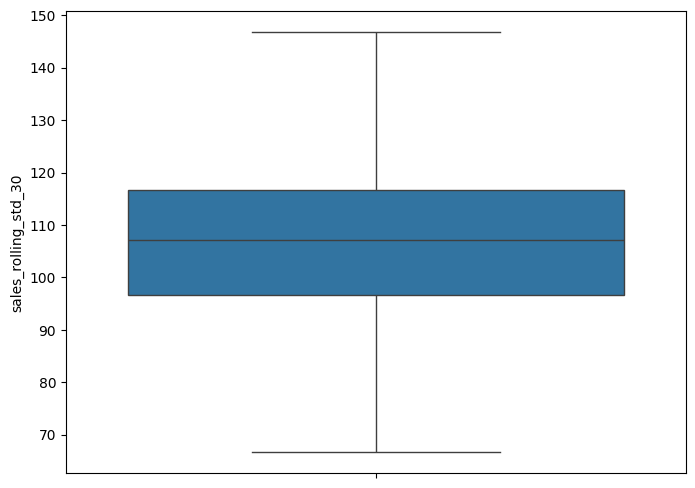

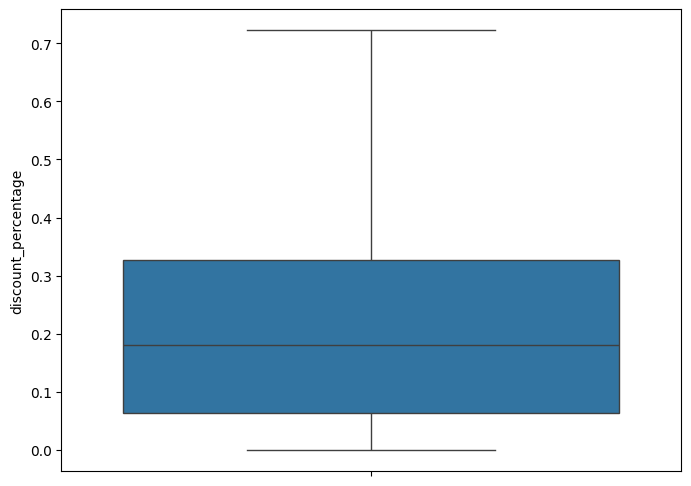

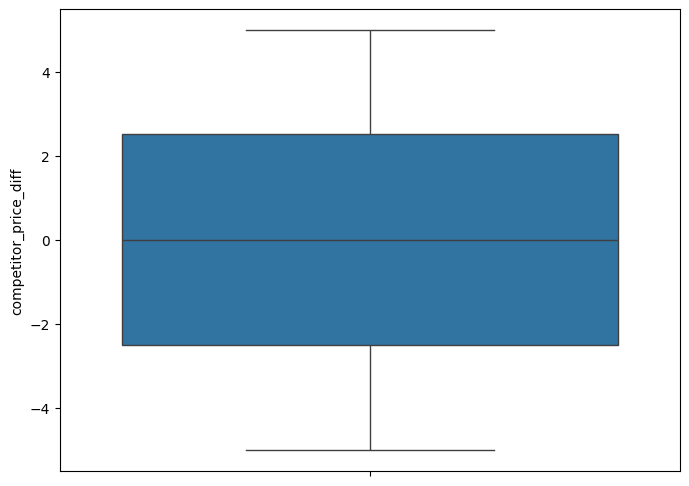

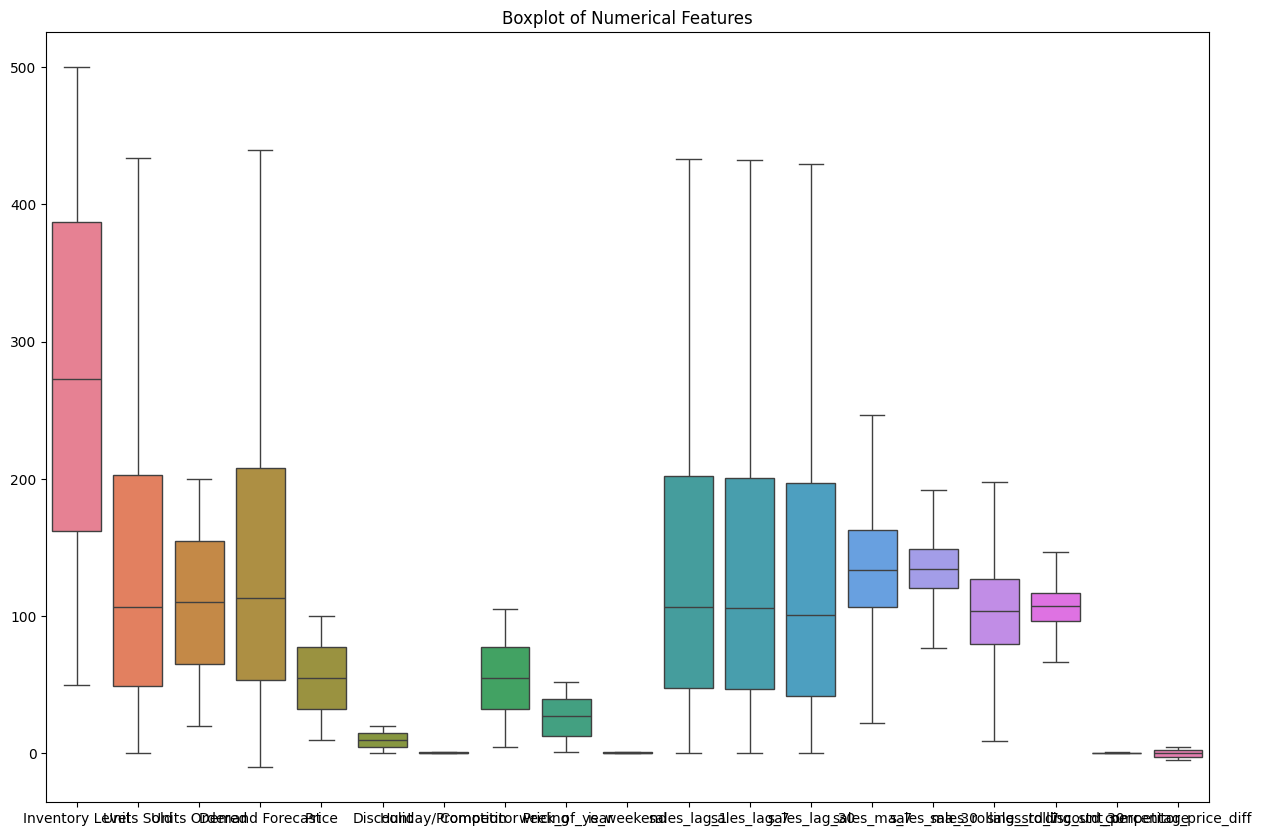

In [ ]:
# Function to cap outliers using IQR (Interquartile Range)
def cap_outliers(df, columns):
    for col in columns:
        # Calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        # Define the lower and upper bounds for acceptable values
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Cap values outside the bounds to the lower or upper threshold
        df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

    return df

# List of columns from which to cap outliers
columns_to_cap_outliers = ["sales_lag_1", "sales_lag_7", "sales_lag_30","sales_ma_7","sales_ma_30","sales_rolling_std_7","sales_rolling_std_30","discount_percentage"]

# Assuming df_rename is your original DataFrame, apply the cap_outliers function
df_capped = cap_outliers(df, columns_to_cap_outliers)

# Display the first few rows of the capped DataFrame
print(df_capped.head())

# Generate individual boxplots for each column after capping outliers
for column in df_capped.select_dtypes(include=['int64','float64']).columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(df_capped[column])
    plt.show()

# Generate a combined boxplot for all selected columns after capping outliers
plt.figure(figsize=(15, 10))
sns.boxplot(data=df_capped.select_dtypes(include=['int64','float64']))
plt.title('Boxplot of Numerical Features')
plt.show()


In [ ]:
import numpy as np

def handle_outliers_iqr(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Replace outliers with median (or clip values within the range)
    df[feature] = np.where((df[feature] < lower_bound) | (df[feature] > upper_bound),
                           df[feature].median(), df[feature])
    return df

# Apply to lag features
features = ["sales_lag_1", "sales_lag_7", "sales_lag_30","sales_ma_7","sales_ma_30","sales_rolling_std_7","sales_rolling_std_30"]
for feature in features:
    df_capped = handle_outliers_iqr(df_capped, feature)

print("Outliers handled using IQR method.")


Outliers handled using IQR method.


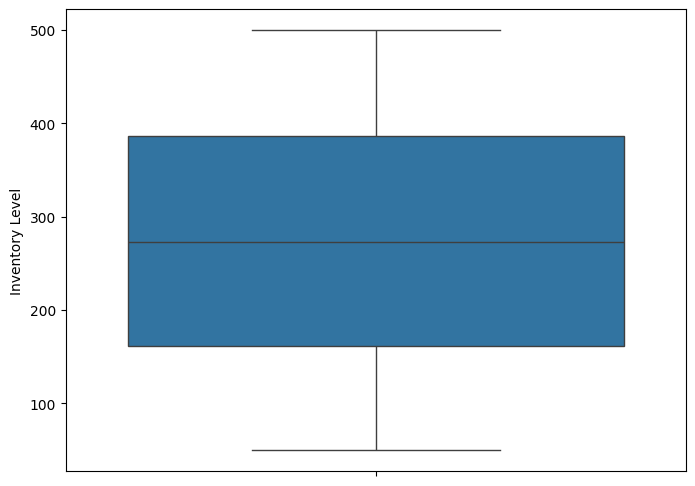

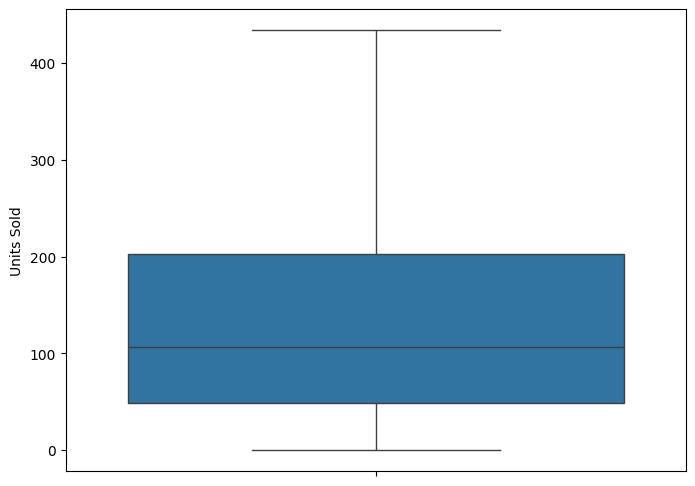

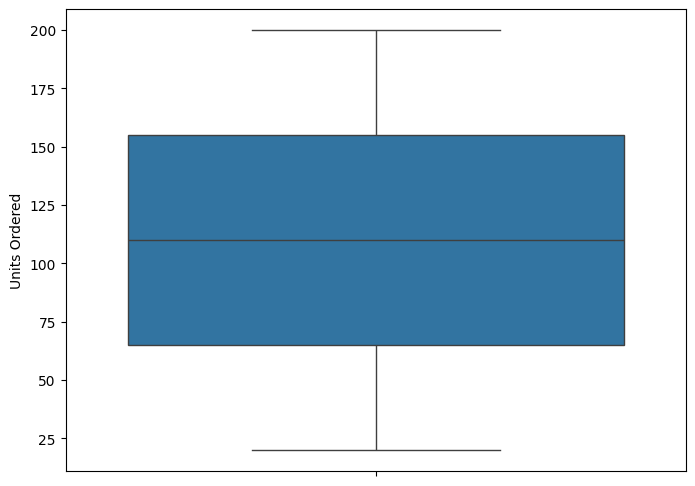

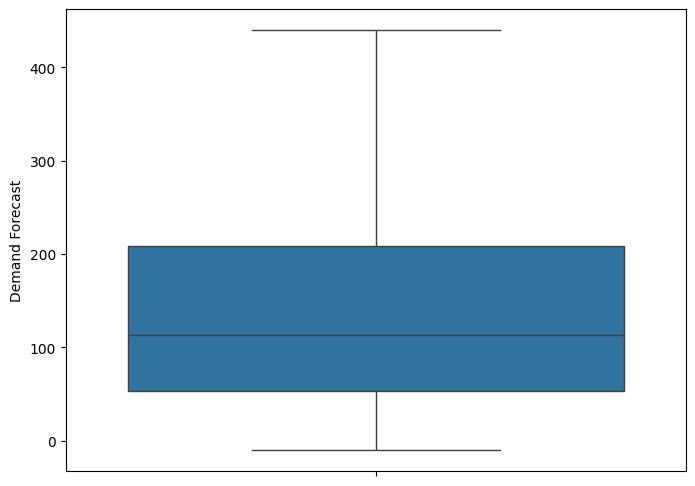

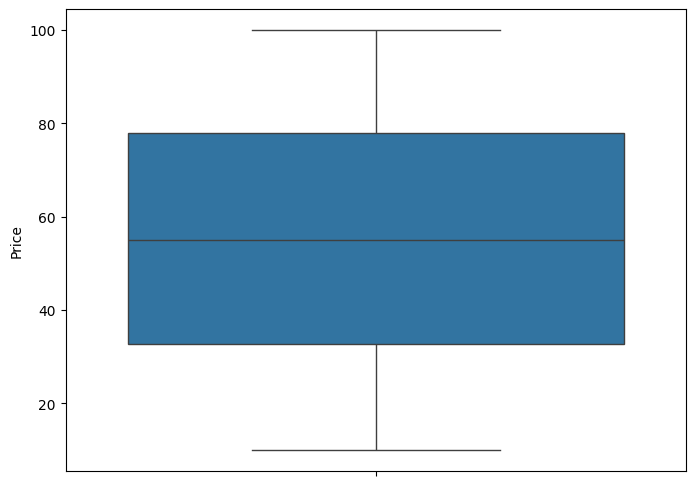

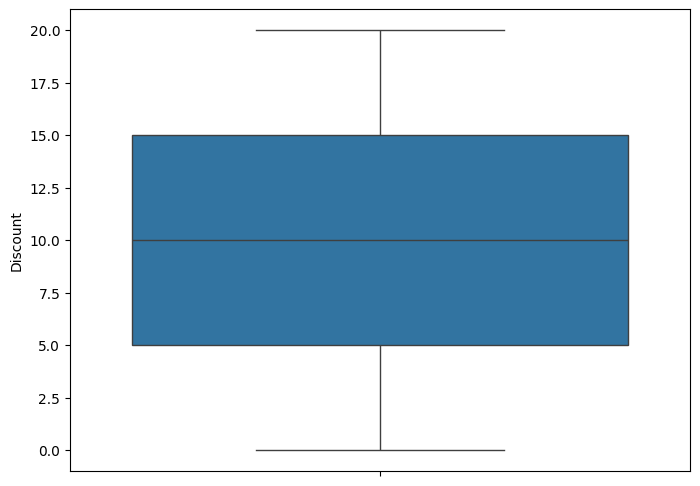

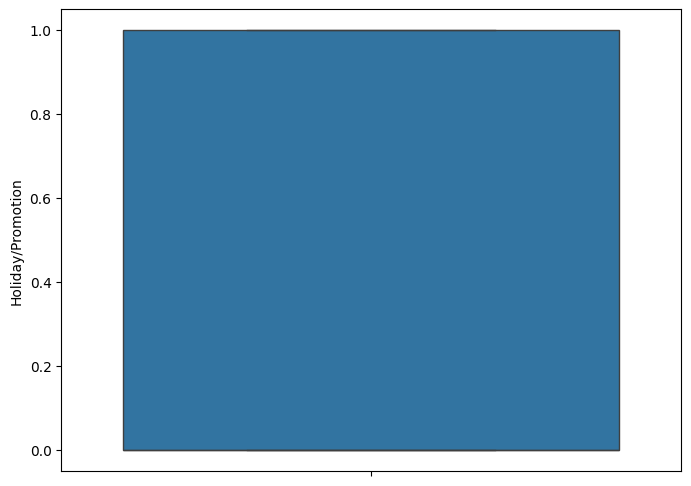

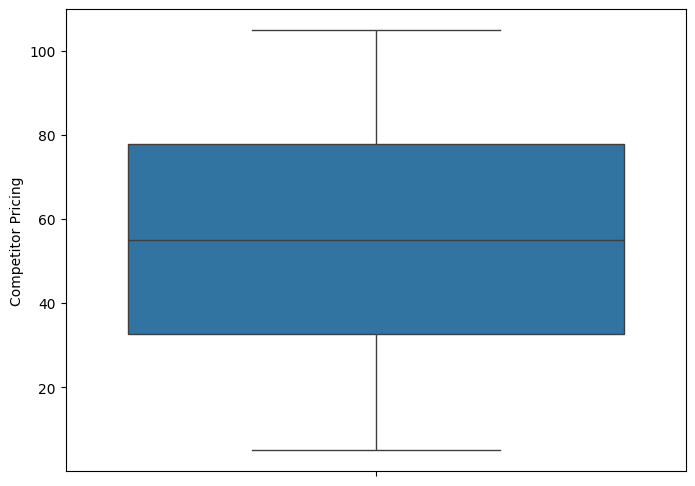

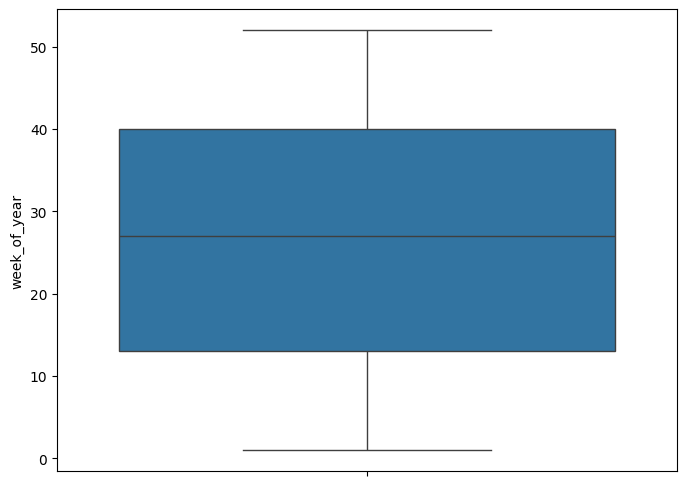

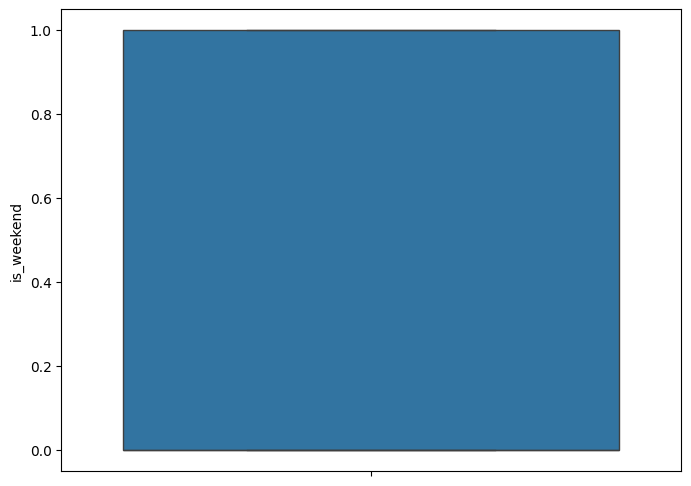

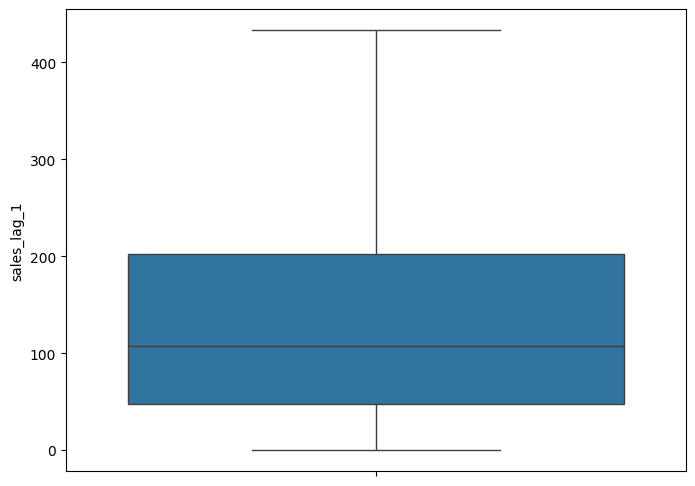

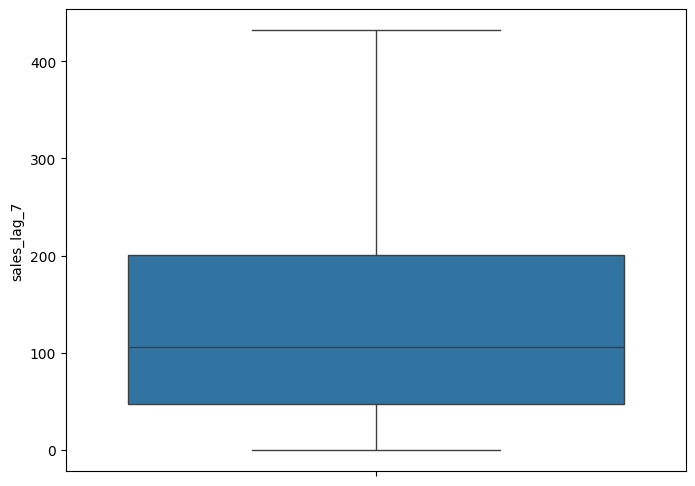

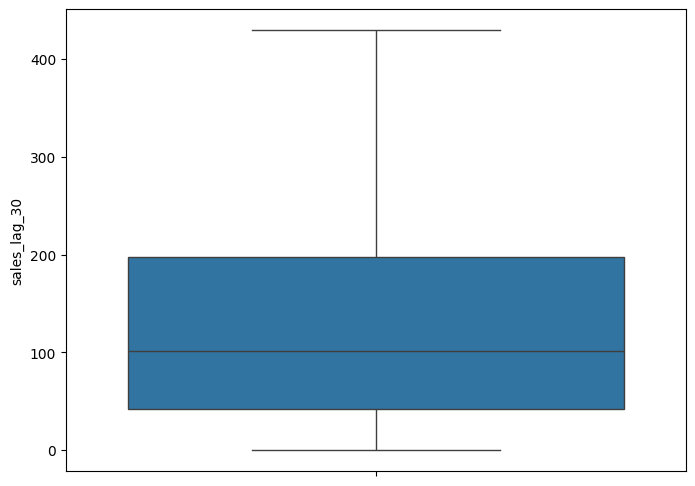

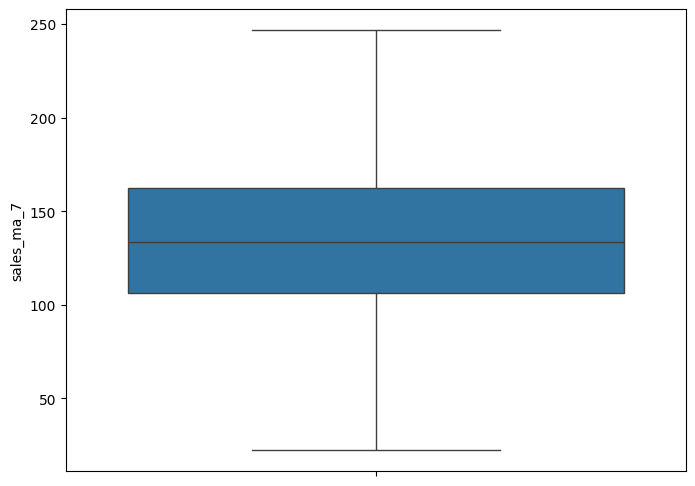

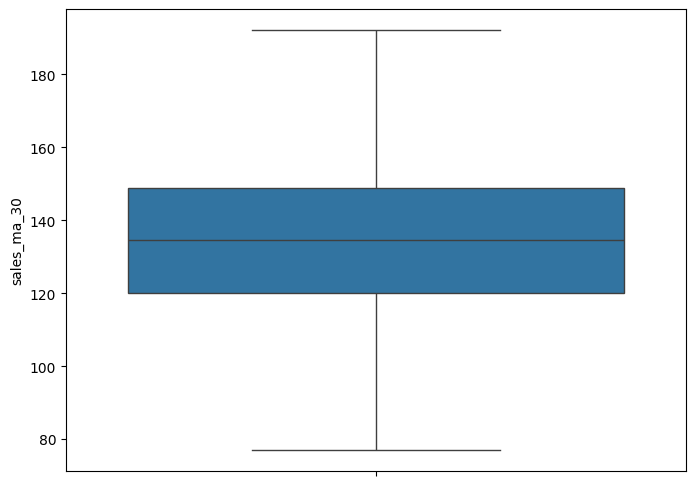

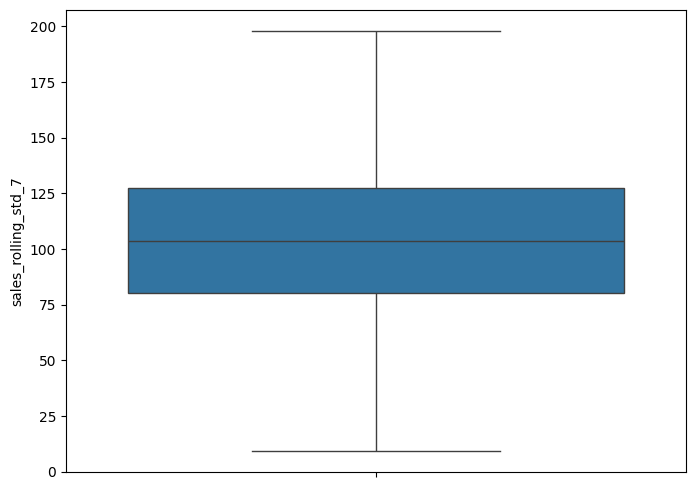

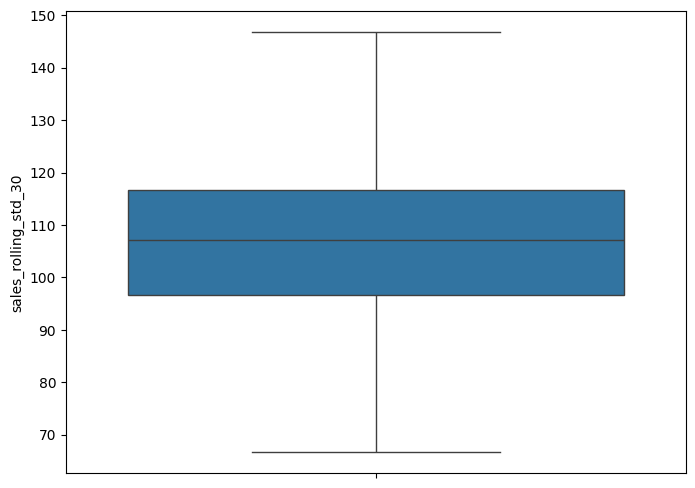

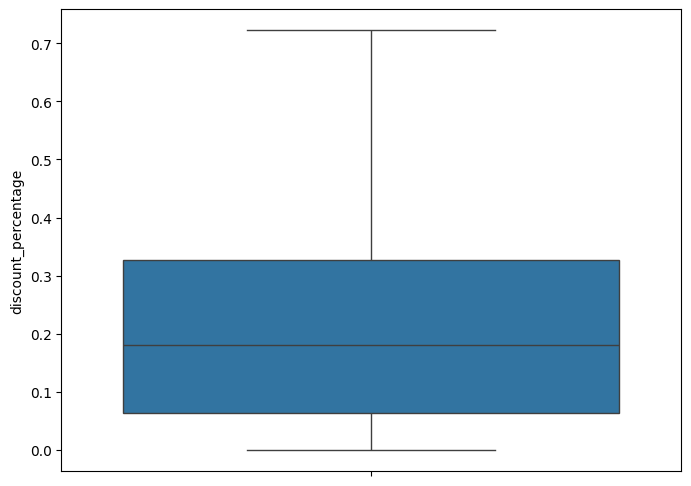

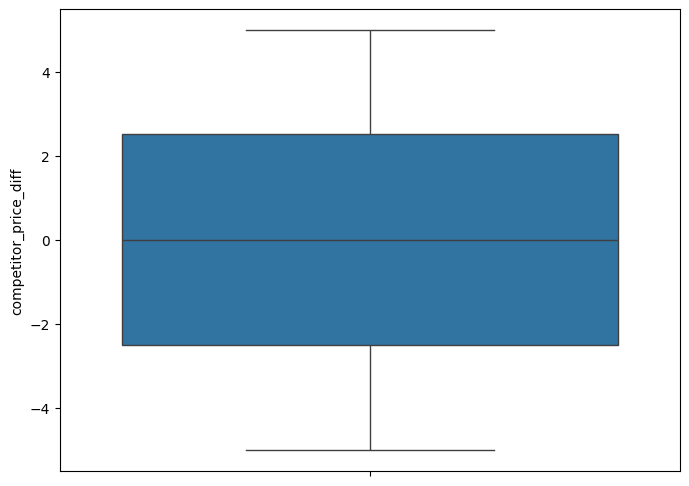

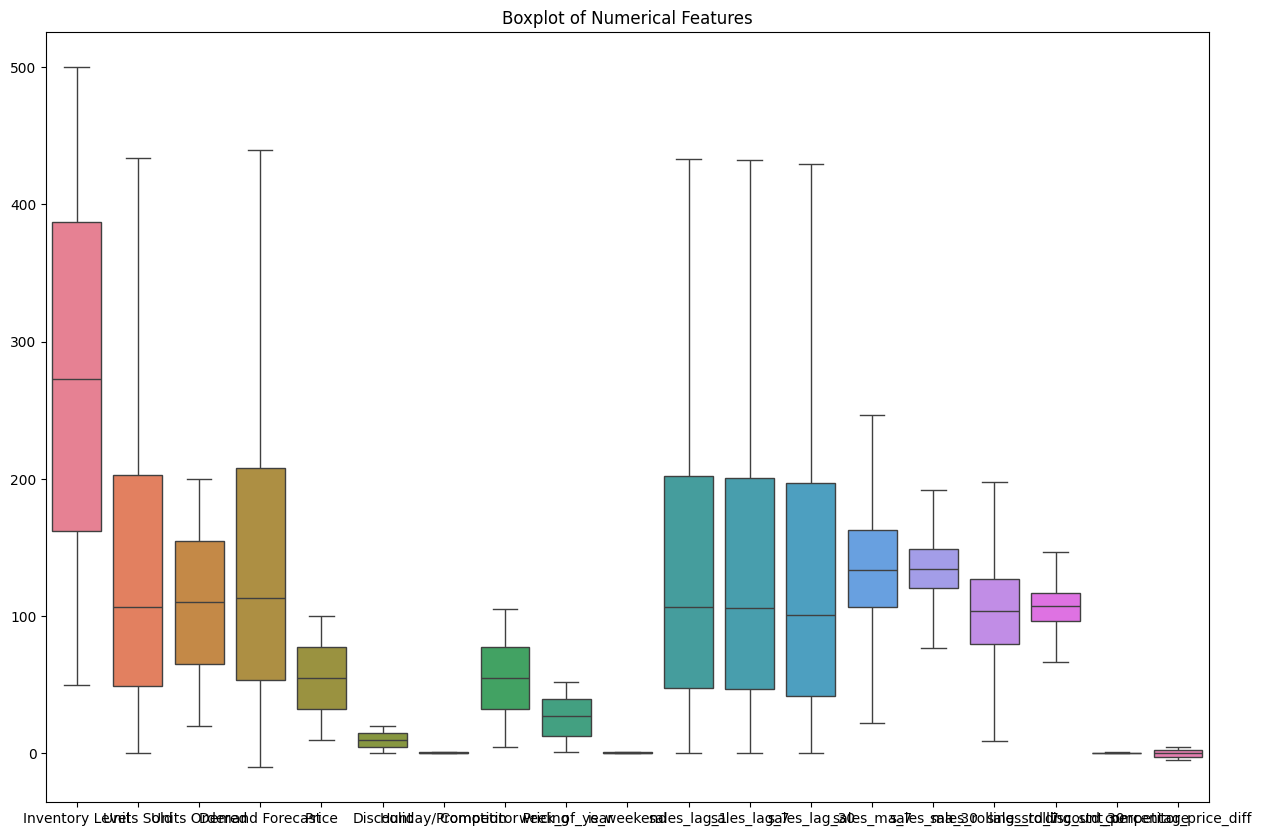

In [ ]:
for column in df_capped.select_dtypes(include=['int64','float64']).columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(df_capped[column])
    plt.show()

plt.figure(figsize=(15, 10))
sns.boxplot(data=df_capped.select_dtypes(include=['int64','float64']))
plt.title('Boxplot of Numerical Features')
plt.show()

In [ ]:
def cap_outliers(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df[feature] = df[feature].clip(lower=lower_bound, upper=upper_bound)
    return df

lag_features = ["sales_lag_1", "sales_lag_7", "sales_lag_30"]
# Apply to lag features

for feature in lag_features:
    df_capped = cap_outliers(df_capped, feature)

print("Outliers handled using capping.")


Outliers handled using capping.


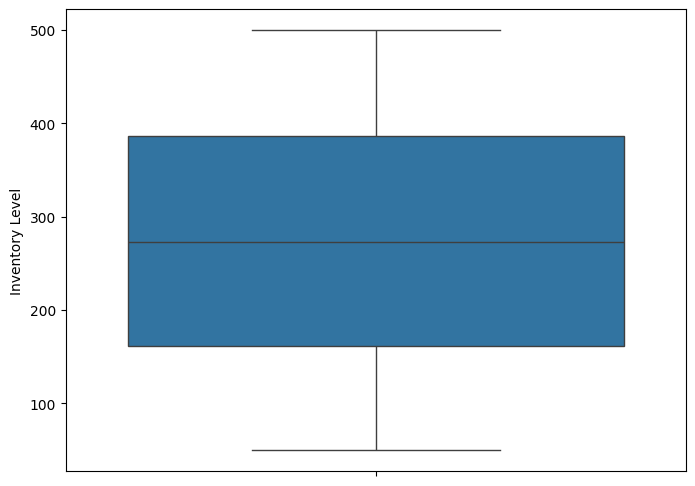

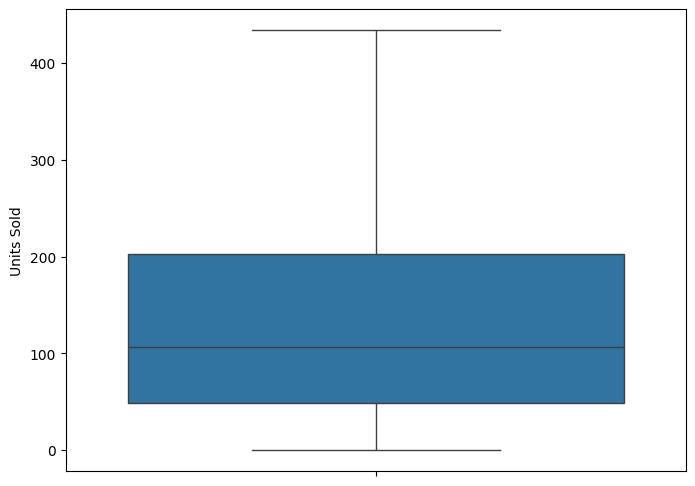

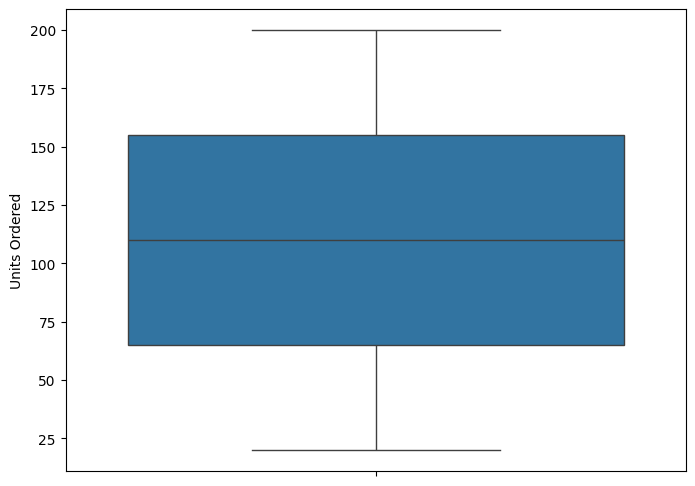

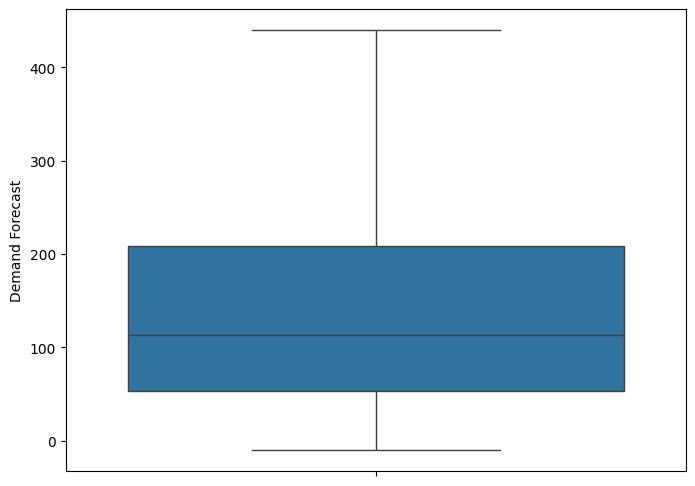

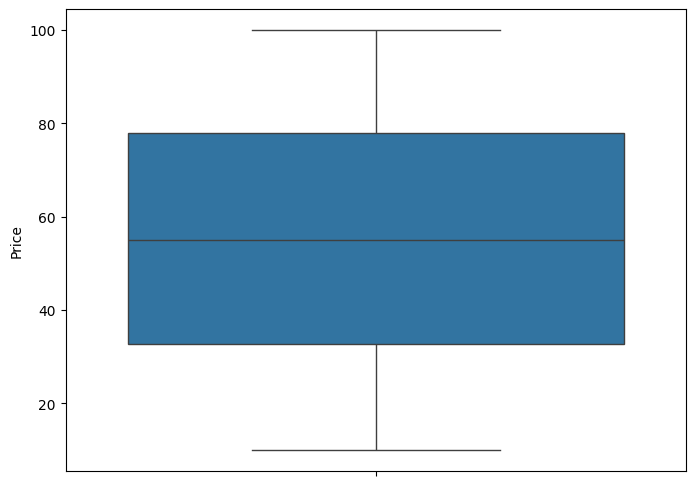

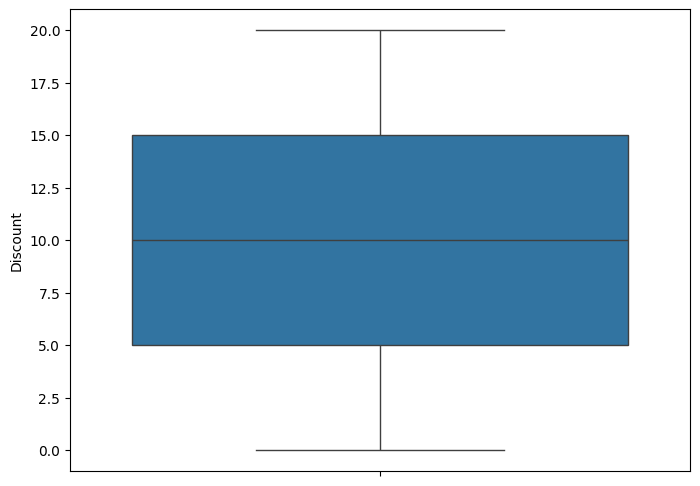

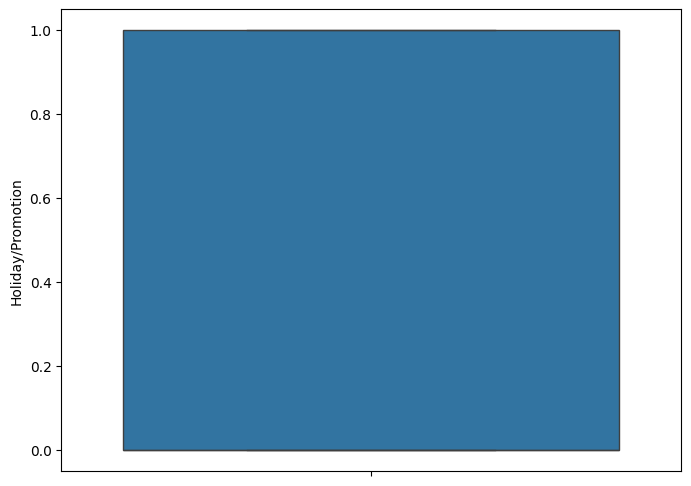

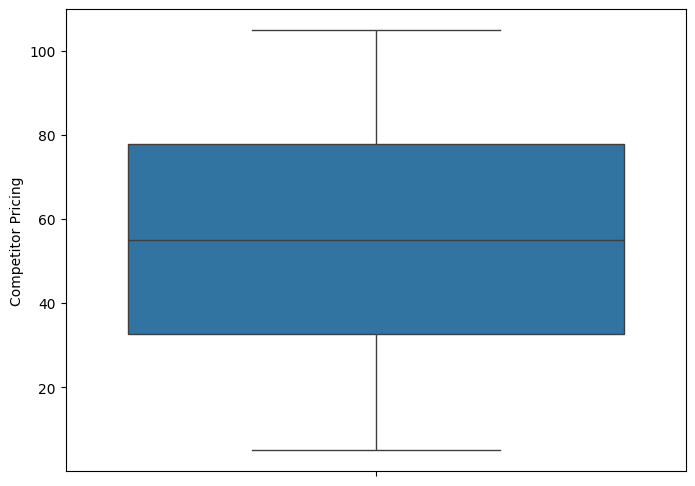

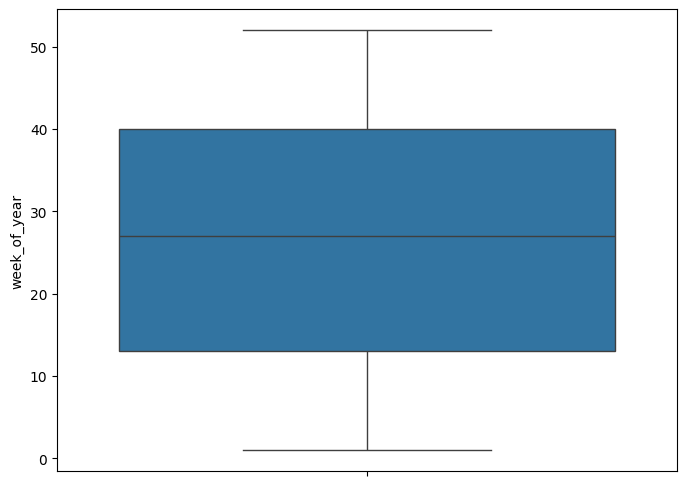

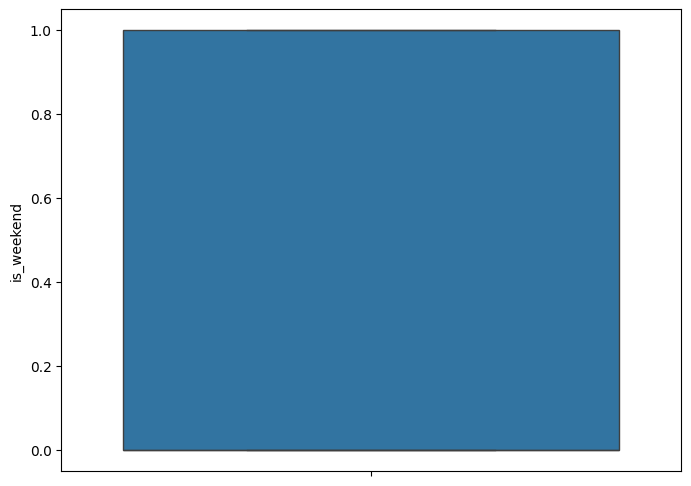

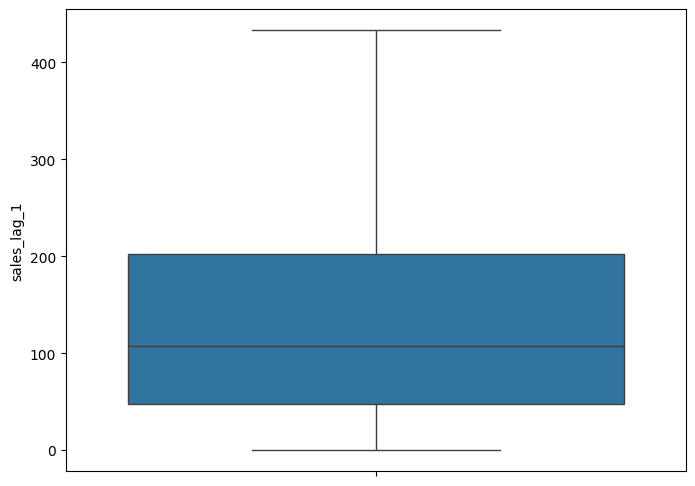

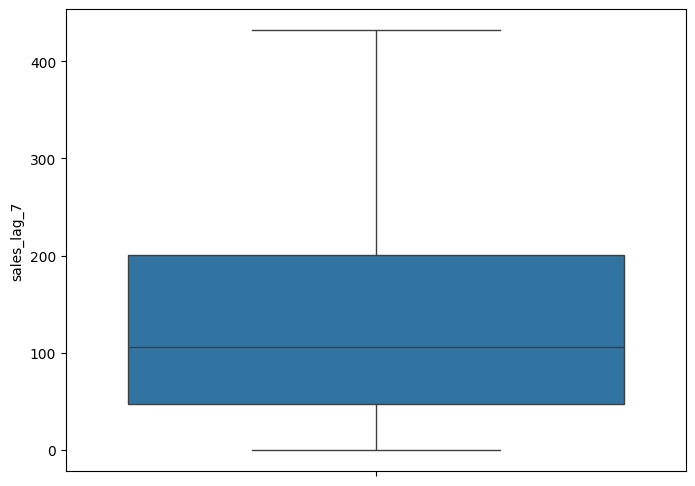

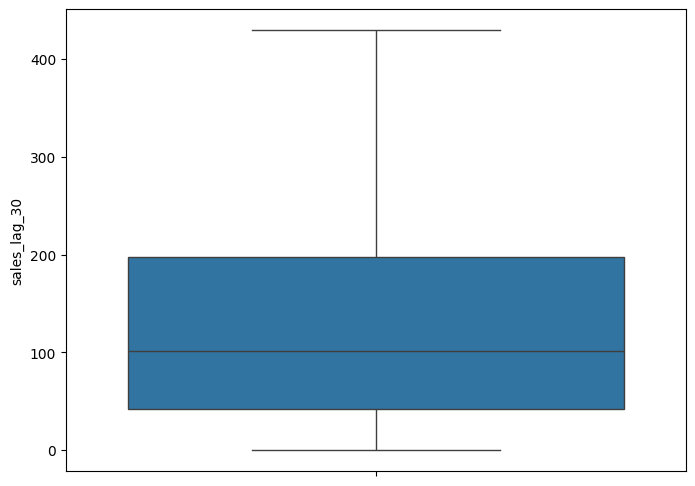

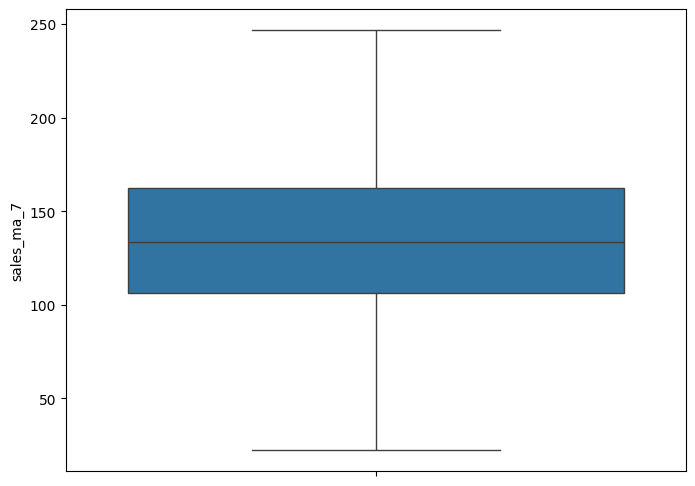

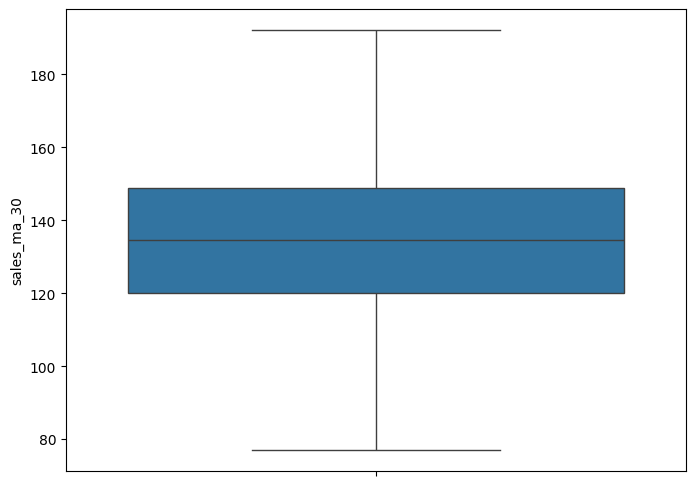

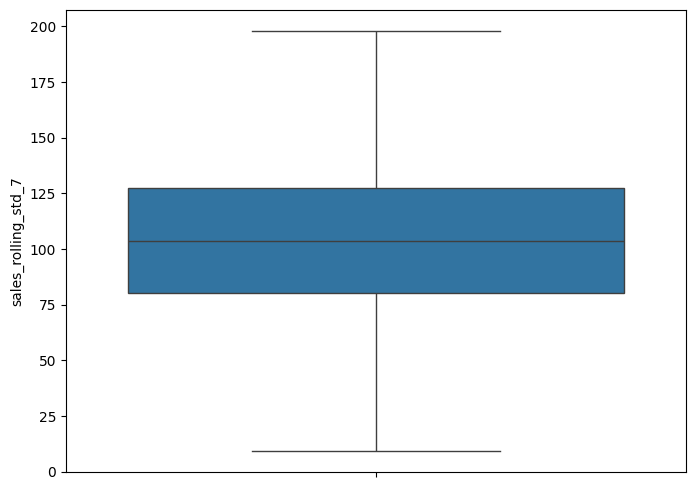

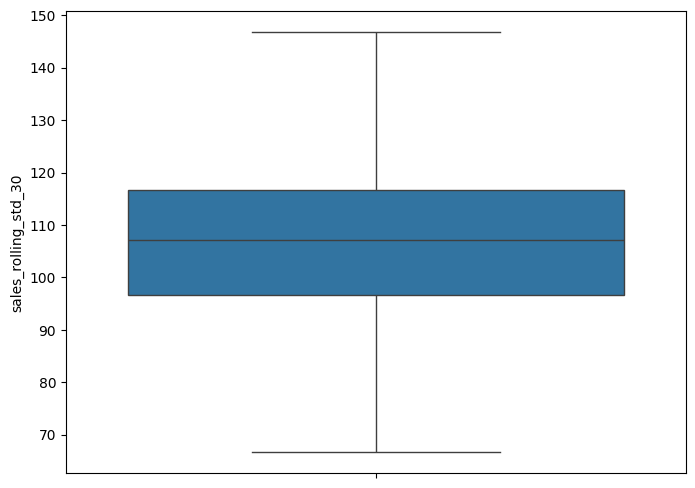

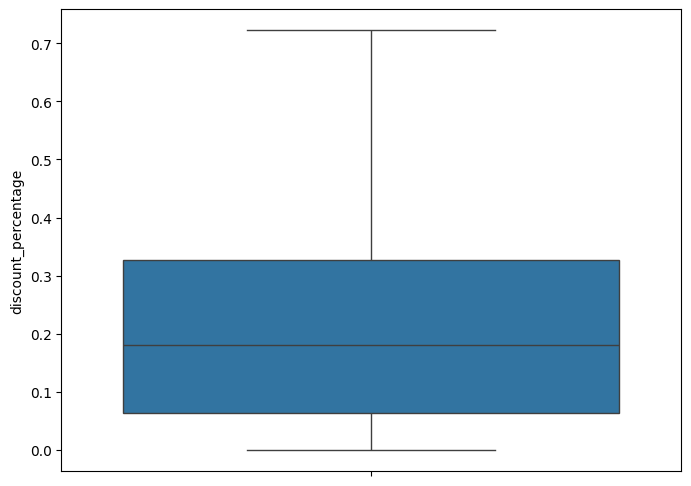

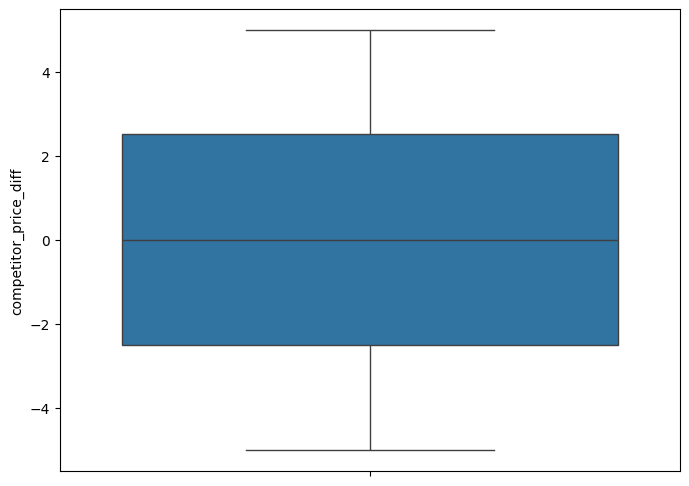

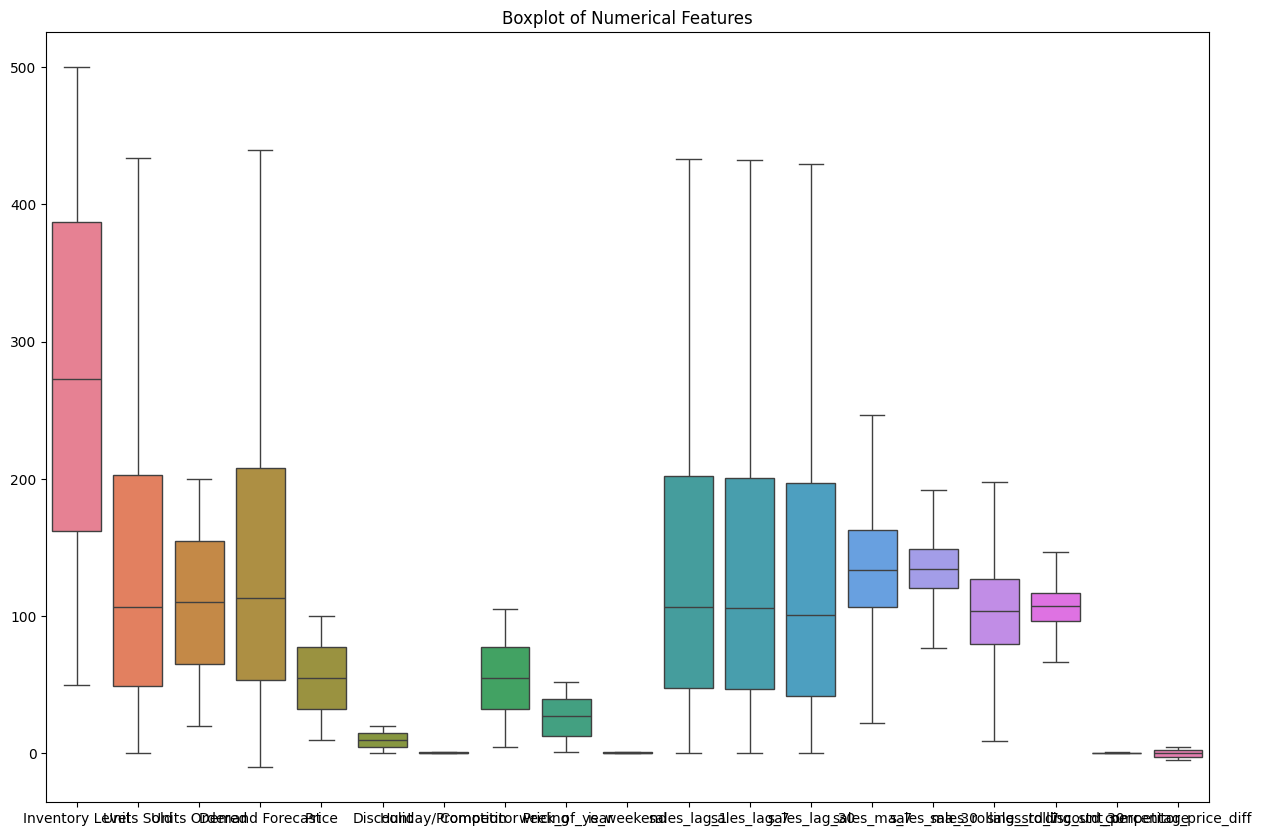

In [ ]:
for column in df_capped.select_dtypes(include=['int64','float64']).columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(df_capped[column])
    plt.show()

plt.figure(figsize=(15, 10))
sns.boxplot(data=df_capped.select_dtypes(include=['int64','float64']))
plt.title('Boxplot of Numerical Features')
plt.show()

## 3. Scaling the numerical values

In [ ]:
def apply_min_max_scaler(df, columns_to_scale):
    # """
    # Scales specified columns of a DataFrame using Min-Max Scaling.

    # Parameters:
    #     df (pd.DataFrame): The input DataFrame to scale.
    #     columns_to_scale (list): List of column names to apply Min-Max scaling.

    # Returns:
    #     pd.DataFrame: The DataFrame with scaled columns.
    # """
    from sklearn.preprocessing import MinMaxScaler
    import pandas as pd

    # Create a copy of the input DataFrame to preserve the original
    df_scaled = df.copy()

    # Initialize the scaler
    scaler = MinMaxScaler()

    # Apply scaling to each specified column
    for column in df.select_dtypes(include=['int64','float64']).columns:
        if column in df.columns:
          # Replace infinite values with NaN
            df_scaled[column] = df_scaled[column].replace([np.inf, -np.inf], np.nan)

            # Fill NaN values with the column's median
            df_scaled[column] = df_scaled[column].fillna(df_scaled[column].median())
            # Clip values to a reasonable range before scaling
            # For example, between the 1st and 99th percentiles
            lower_bound = df_scaled[column].quantile(0.01)
            upper_bound = df_scaled[column].quantile(0.99)
            df_scaled[column] = df_scaled[column].clip(lower=lower_bound, upper=upper_bound)

            df_scaled[column] = scaler.fit_transform(df_scaled[[column]]) # Changed this line: scaling the clipped and filled df_scaled
    return df_scaled

columns_to_scale = [df_capped.select_dtypes(include=['int64','float64']).columns]
df_scaled = apply_min_max_scaler(df_capped, columns_to_scale)

df_scaled

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,...,is_weekend,sales_lag_1,sales_lag_7,sales_lag_30,sales_ma_7,sales_ma_30,sales_rolling_std_7,sales_rolling_std_30,discount_percentage,competitor_price_diff
0,2022-01-01,S001,P0001,Groceries,North,0.399093,0.290993,0.191011,0.307660,0.256291,...,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.826302,0.110317
100,2022-01-02,S001,P0001,Groceries,West,0.138322,0.184758,0.466292,0.210851,0.193380,...,1.0,0.291667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.495190,0.799796
200,2022-01-03,S001,P0001,Electronics,West,0.224490,0.009238,0.943820,0.011495,0.587282,...,0.0,0.185185,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.441485,0.041879
300,2022-01-04,S001,P0001,Groceries,South,0.068027,0.131640,0.966292,0.119641,0.759352,...,0.0,0.009259,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.266575,0.306435
400,2022-01-05,S001,P0001,Groceries,South,0.414966,0.337182,0.089888,0.341349,0.199161,...,0.0,0.131944,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.972632,0.595506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72699,2023-12-28,S005,P0020,Groceries,South,0.324263,0.127021,0.033708,0.113518,0.123101,...,0.0,0.317130,0.370370,0.065192,0.398571,0.663966,0.447519,0.652695,0.318174,0.861083
72799,2023-12-29,S005,P0020,Clothing,East,0.886621,0.616628,0.050562,0.608286,0.846633,...,0.0,0.127315,0.527778,0.426077,0.427143,0.690437,0.508385,0.680150,0.323453,0.708887
72899,2023-12-30,S005,P0020,Toys,North,0.444444,0.341801,0.898876,0.370144,0.777488,...,1.0,0.618056,0.509259,0.509895,0.376429,0.668637,0.453016,0.670007,0.174139,0.827375
72999,2023-12-31,S005,P0020,Furniture,East,0.020408,0.090069,0.438202,0.135165,0.905690,...,1.0,0.342593,0.013889,0.351572,0.400714,0.634068,0.411606,0.693906,0.076223,0.589377


## 4. Label Encoding the categorical values

In [ ]:
def Lebel_Encoding(df):
    from sklearn.preprocessing import LabelEncoder
    df_Encoded = df.copy()
    for column in df.select_dtypes(include=['object','category']).columns:


            encoder = LabelEncoder()
            df_Encoded[column] = encoder.fit_transform(df[column])
    return df_Encoded

df_encoded = Lebel_Encoding(df_scaled)
df_encoded

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,...,is_weekend,sales_lag_1,sales_lag_7,sales_lag_30,sales_ma_7,sales_ma_30,sales_rolling_std_7,sales_rolling_std_30,discount_percentage,competitor_price_diff
0,2022-01-01,0,0,3,1,0.399093,0.290993,0.191011,0.307660,0.256291,...,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.826302,0.110317
100,2022-01-02,0,0,3,3,0.138322,0.184758,0.466292,0.210851,0.193380,...,1.0,0.291667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.495190,0.799796
200,2022-01-03,0,0,1,3,0.224490,0.009238,0.943820,0.011495,0.587282,...,0.0,0.185185,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.441485,0.041879
300,2022-01-04,0,0,3,2,0.068027,0.131640,0.966292,0.119641,0.759352,...,0.0,0.009259,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.266575,0.306435
400,2022-01-05,0,0,3,2,0.414966,0.337182,0.089888,0.341349,0.199161,...,0.0,0.131944,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.972632,0.595506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72699,2023-12-28,4,19,3,2,0.324263,0.127021,0.033708,0.113518,0.123101,...,0.0,0.317130,0.370370,0.065192,0.398571,0.663966,0.447519,0.652695,0.318174,0.861083
72799,2023-12-29,4,19,0,0,0.886621,0.616628,0.050562,0.608286,0.846633,...,0.0,0.127315,0.527778,0.426077,0.427143,0.690437,0.508385,0.680150,0.323453,0.708887
72899,2023-12-30,4,19,4,1,0.444444,0.341801,0.898876,0.370144,0.777488,...,1.0,0.618056,0.509259,0.509895,0.376429,0.668637,0.453016,0.670007,0.174139,0.827375
72999,2023-12-31,4,19,2,0,0.020408,0.090069,0.438202,0.135165,0.905690,...,1.0,0.342593,0.013889,0.351572,0.400714,0.634068,0.411606,0.693906,0.076223,0.589377


**Dropping unnecessary columns**

In [ ]:
# Drop non-numeric features for modeling
df_encoded = df_encoded.drop(columns=["Store ID", "Product ID"])
df_encoded

,Date,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,...,is_weekend,sales_lag_1,sales_lag_7,sales_lag_30,sales_ma_7,sales_ma_30,sales_rolling_std_7,sales_rolling_std_30,discount_percentage,competitor_price_diff
0,2022-01-01,3,1,0.399093,0.290993,0.191011,0.307660,0.256291,1.00,1,...,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.826302,0.110317
100,2022-01-02,3,3,0.138322,0.184758,0.466292,0.210851,0.193380,0.50,0,...,1.0,0.291667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.495190,0.799796
200,2022-01-03,1,3,0.224490,0.009238,0.943820,0.011495,0.587282,1.00,1,...,0.0,0.185185,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.441485,0.041879
300,2022-01-04,3,2,0.068027,0.131640,0.966292,0.119641,0.759352,0.75,0,...,0.0,0.009259,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.266575,0.306435
400,2022-01-05,3,2,0.414966,0.337182,0.089888,0.341349,0.199161,1.00,3,...,0.0,0.131944,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.972632,0.595506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72699,2023-12-28,3,2,0.324263,0.127021,0.033708,0.113518,0.123101,0.25,3,...,0.0,0.317130,0.370370,0.065192,0.398571,0.663966,0.447519,0.652695,0.318174,0.861083
72799,2023-12-29,0,0,0.886621,0.616628,0.050562,0.608286,0.846633,1.00,3,...,0.0,0.127315,0.527778,0.426077,0.427143,0.690437,0.508385,0.680150,0.323453,0.708887
72899,2023-12-30,4,1,0.444444,0.341801,0.898876,0.370144,0.777488,0.50,0,...,1.0,0.618056,0.509259,0.509895,0.376429,0.668637,0.453016,0.670007,0.174139,0.827375
72999,2023-12-31,2,0,0.020408,0.090069,0.438202,0.135165,0.905690,0.25,2,...,1.0,0.342593,0.013889,0.351572,0.400714,0.634068,0.411606,0.693906,0.076223,0.589377


**Correlation Matrix**

In [ ]:
df_encoded.corr()

,Date,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,...,is_weekend,sales_lag_1,sales_lag_7,sales_lag_30,sales_ma_7,sales_ma_30,sales_rolling_std_7,sales_rolling_std_30,discount_percentage,competitor_price_diff
Date,1.000000,-0.003334,-0.002042,-0.001044,-0.002038,-0.000218,-0.002071,-0.009174,-0.002233,0.001079,...,-0.001504,0.001017,0.018469,0.083427,0.028521,0.163807,0.034186,0.169204,0.004092,0.002031
Category,-0.003334,1.000000,0.000841,0.001447,0.000499,-0.001694,0.000472,0.001393,-0.001784,-0.000624,...,0.002317,0.003116,-0.001762,0.002644,-0.002504,-0.002060,-0.009992,-0.006469,-0.000906,-0.003799
Region,-0.002042,0.000841,1.000000,-0.006850,-0.002954,0.003173,-0.002327,-0.003588,-0.002696,0.000209,...,-0.001620,0.001367,-0.003549,0.002194,-0.002124,-0.002733,0.002826,-0.000961,-0.000025,0.001497
Inventory Level,-0.001044,0.001447,-0.006850,1.000000,0.590223,0.001061,0.588835,0.009133,0.004896,0.001902,...,0.002215,-0.004907,-0.000994,-0.008570,0.214737,0.094678,0.123923,0.060206,-0.003427,0.002588
Units Sold,-0.002038,0.000499,-0.002954,0.590223,1.000000,-0.000940,0.996875,0.001287,0.002407,0.004728,...,-0.002374,-0.000466,0.002161,-0.005853,0.367888,0.158173,0.226154,0.108024,-0.000791,0.001498
Units Ordered,-0.000218,-0.001694,0.003173,0.001061,-0.000940,1.000000,-0.001112,0.004210,-0.000936,-0.001064,...,-0.004941,0.000899,-0.011567,-0.003580,-0.002316,-0.000520,-0.003878,-0.004266,-0.005258,0.003731
Demand Forecast,-0.002071,0.000472,-0.002327,0.588835,0.996875,-0.001112,1.000000,0.000869,0.002164,0.004835,...,-0.002341,-0.000290,0.001876,-0.005863,0.366813,0.158147,0.225015,0.107881,-0.000868,0.001331
Price,-0.009174,0.001393,-0.003588,0.009133,0.001287,0.004210,0.000869,1.000000,0.001515,-0.007721,...,-0.001206,0.005374,-0.004096,-0.000860,0.000341,-0.004219,0.002595,-0.003399,-0.550707,0.003369
Discount,-0.002233,-0.001784,-0.002696,0.004896,0.002407,-0.000936,0.002164,0.001515,1.000000,-0.002302,...,0.003032,-0.005903,0.002310,-0.001932,-0.001967,-0.002227,-0.000368,0.002358,0.714418,0.004161
Weather Condition,0.001079,-0.000624,0.000209,0.001902,0.004728,-0.001064,0.004835,-0.007721,-0.002302,1.000000,...,-0.001705,0.000355,0.002422,-0.000032,0.000031,0.004149,0.001033,0.005467,0.001002,0.002032


**Correlation Heatmap**

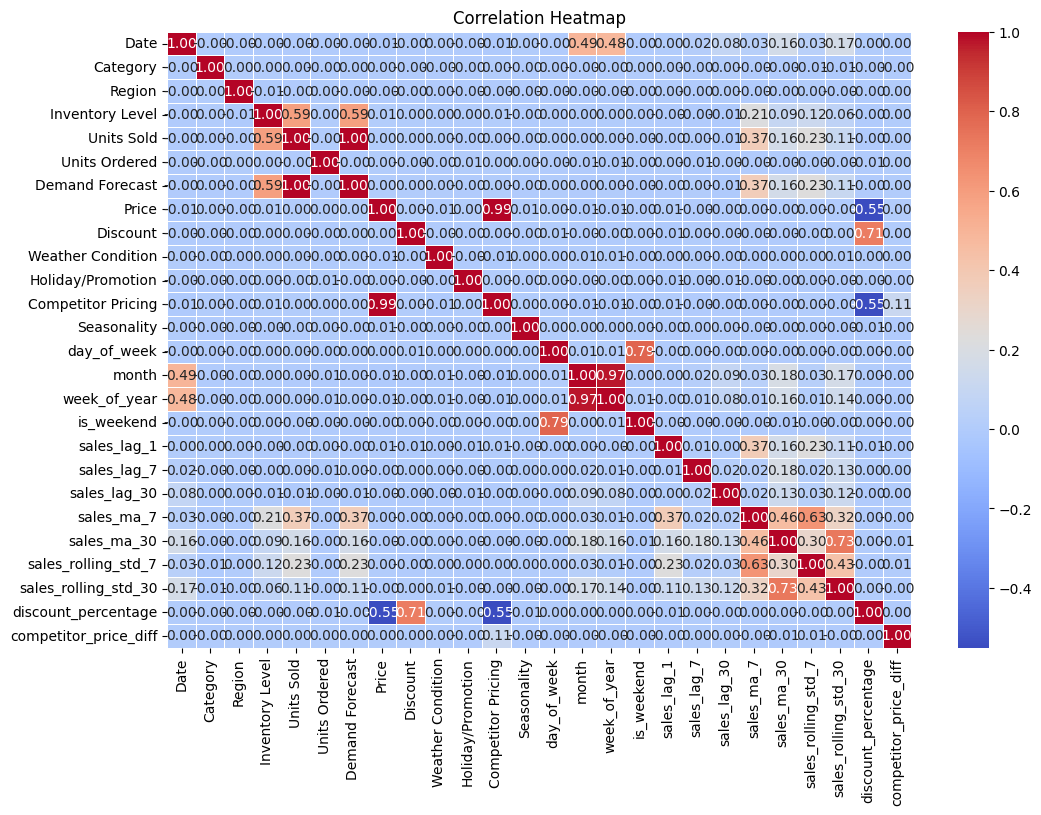

In [ ]:
#Calculate the correlation matrix for numerical features
corr_matrix = df_encoded.corr()

# Step 4: Generate a heatmap to visualize feature relationships
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
df_encoded.to_csv("df_encoded.csv", index=False)

**Time Series Plotting**

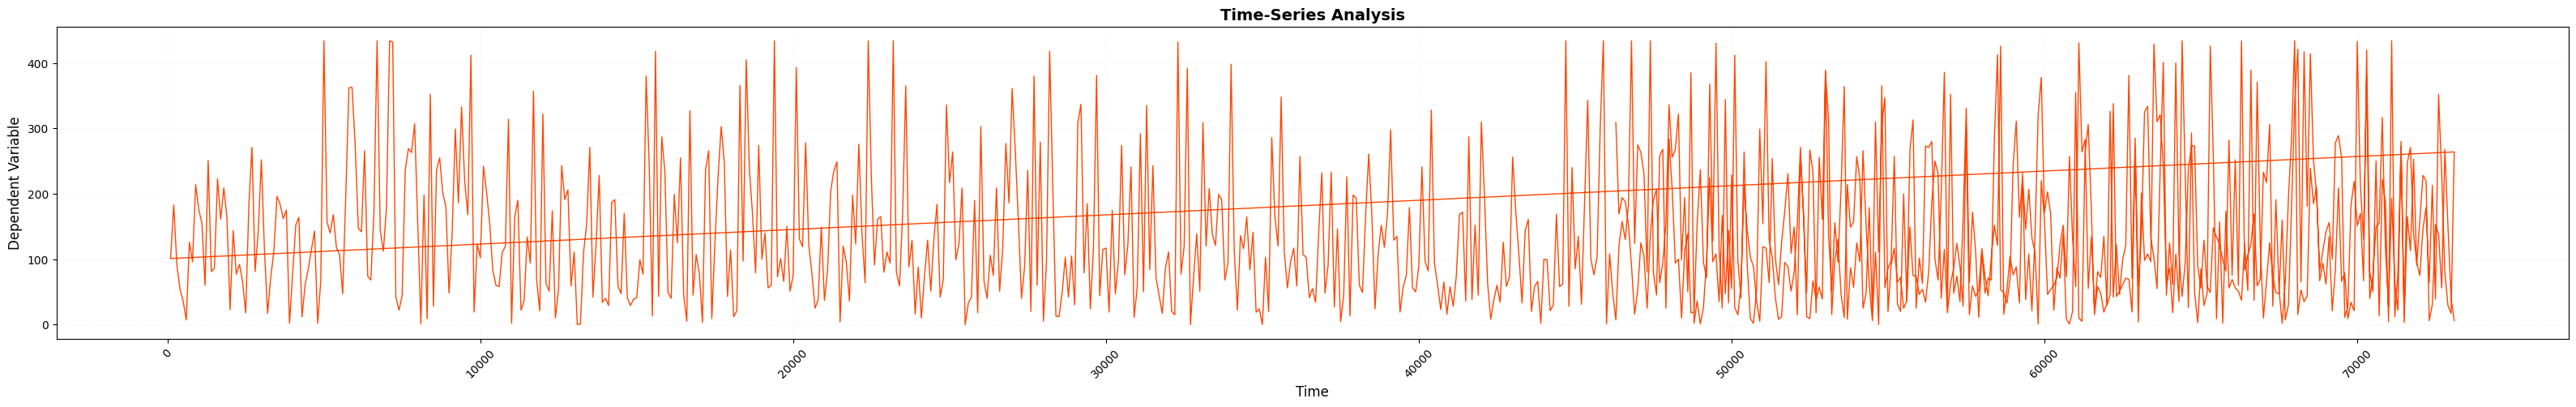

In [ ]:
import matplotlib.pyplot as plt
#  Plot time-series data
plt.figure(figsize=(40, 5))
plt.plot(df_capped.tail(1000).index, df_capped.tail(1000)["Units Sold"], color="orangered", linewidth=1)

#  Add title and labels
plt.title("Time-Series Analysis", fontsize=14, fontweight='bold')
plt.xlabel("Time", fontsize=12)
plt.ylabel("Dependent Variable", fontsize=12)

#  Customize axes
plt.grid(True, linestyle="--", alpha=0.1)
plt.xticks(rotation=45)

#  Show the plot
plt.show()

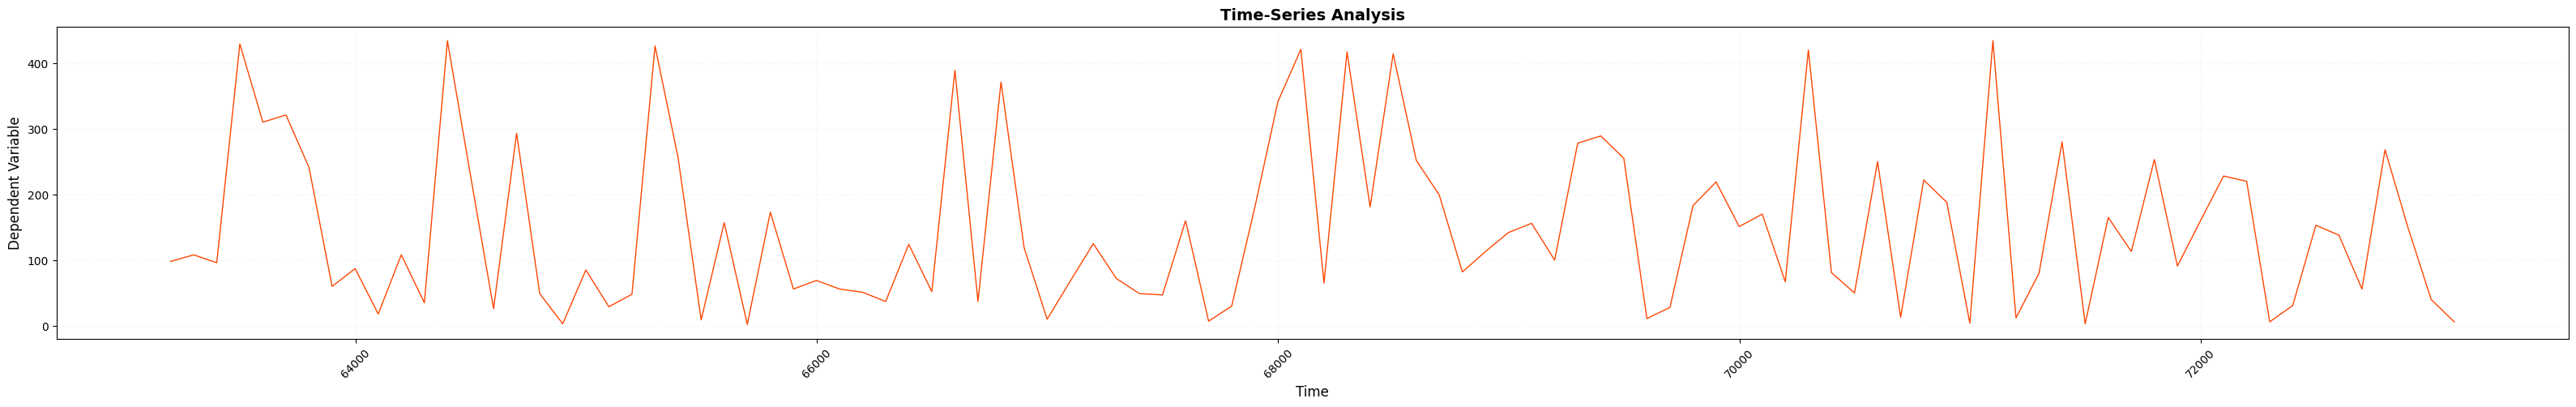

In [ ]:
import matplotlib.pyplot as plt
#  Plot time-series data
plt.figure(figsize=(40, 5))
df_sampled = df_capped.tail(100)  # Take every 100th row
plt.plot(df_sampled.index, df_sampled["Units Sold"], color="orangered", linewidth=1)

#  Add title and labels
plt.title("Time-Series Analysis", fontsize=14, fontweight='bold')
plt.xlabel("Time", fontsize=12)
plt.ylabel("Dependent Variable", fontsize=12)

#  Customize axes
plt.grid(True, linestyle="--", alpha=0.1)
plt.xticks(rotation=45)

#  Show the plot
plt.show()


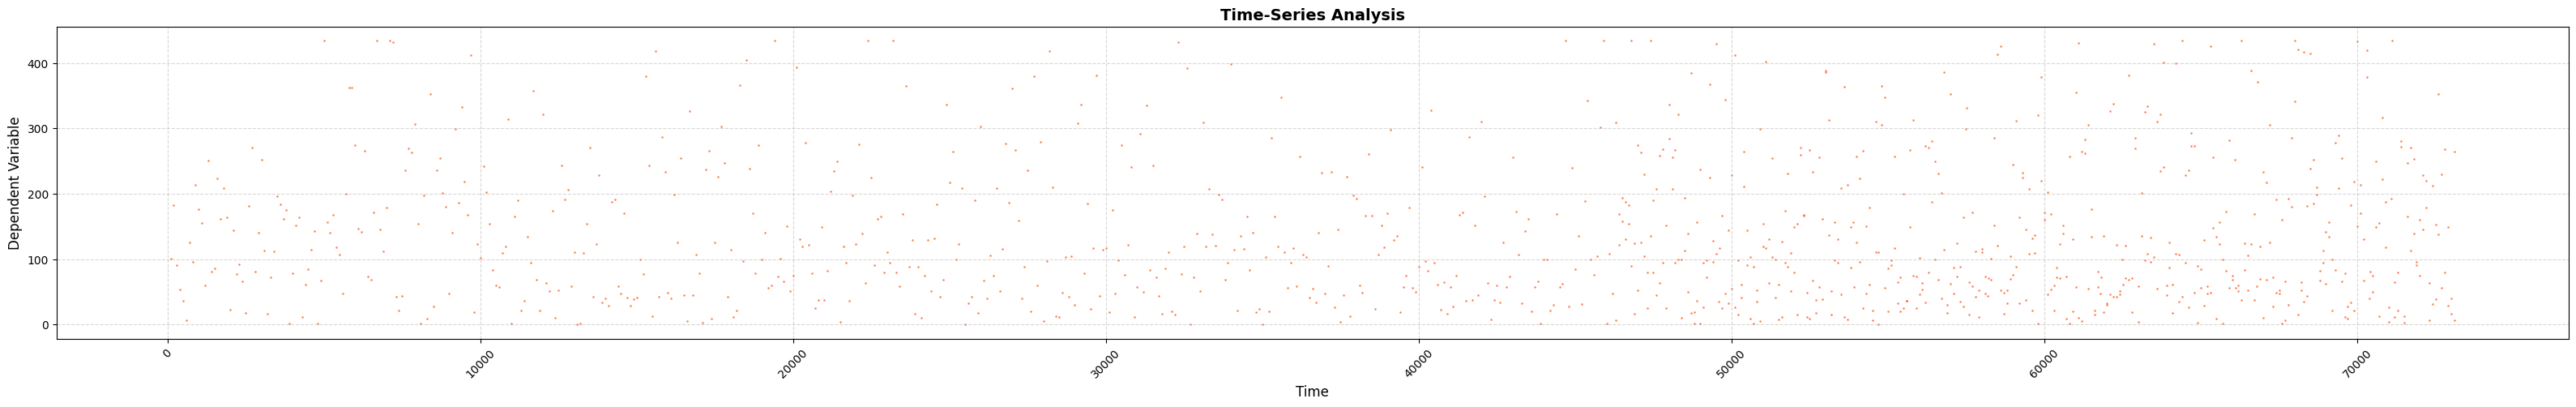

In [ ]:
import matplotlib.pyplot as plt
#  Plot time-series data
plt.figure(figsize=(40, 5))
plt.scatter(df_capped.tail(1000).index, df_capped.tail(1000)["Units Sold"], color="orangered", s=1, alpha=0.5)

#  Add title and labels
plt.title("Time-Series Analysis", fontsize=14, fontweight='bold')
plt.xlabel("Time", fontsize=12)
plt.ylabel("Dependent Variable", fontsize=12)

#  Customize axes
plt.grid(True, linestyle="--", alpha=0.5)
plt.xticks(rotation=45)

#  Show the plot
plt.show()


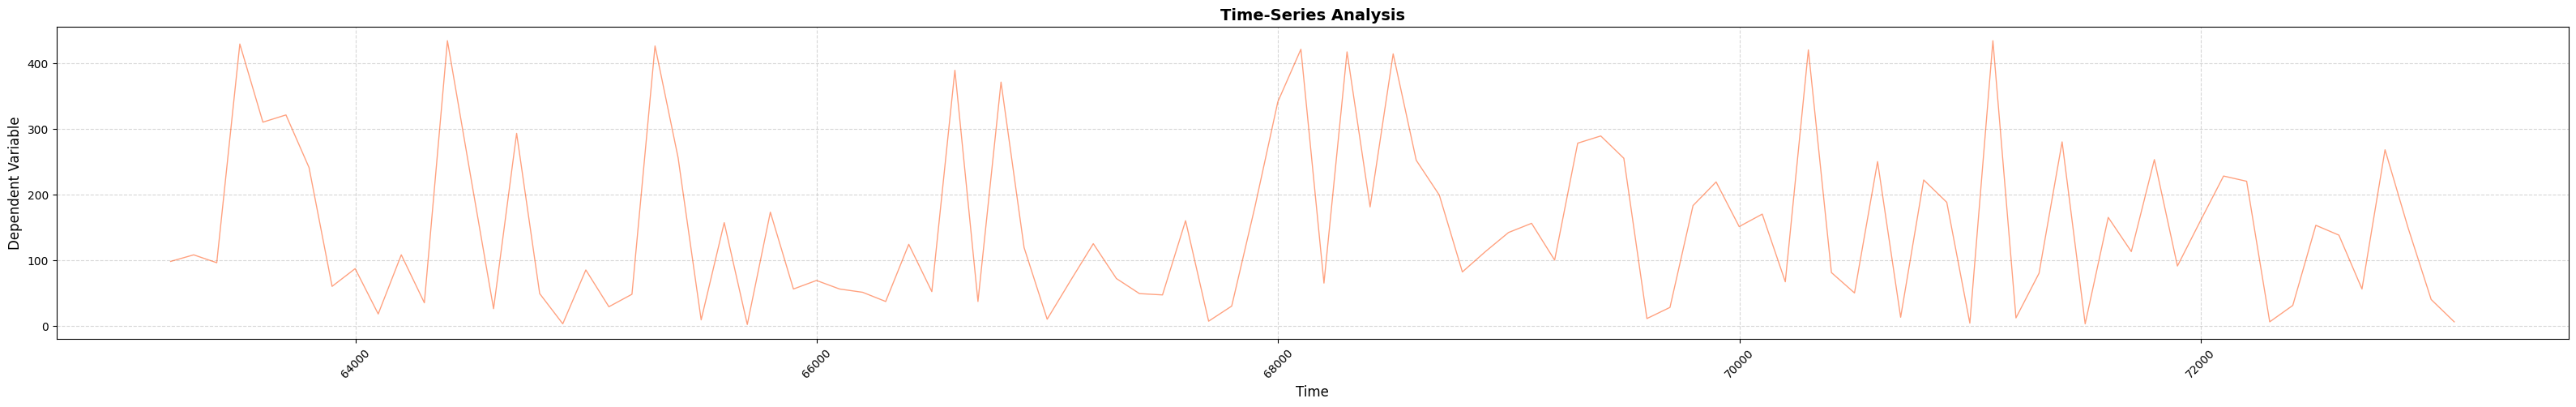

In [ ]:
import matplotlib.pyplot as plt
#  Plot time-series data
plt.figure(figsize=(40, 5))
plt.plot(df_capped.tail(100).index, df_capped.tail(100)["Units Sold"], color="orangered", linewidth=1, alpha=0.5)


#  Add title and labels
plt.title("Time-Series Analysis", fontsize=14, fontweight='bold')
plt.xlabel("Time", fontsize=12)
plt.ylabel("Dependent Variable", fontsize=12)

#  Customize axes
plt.grid(True, linestyle="--", alpha=0.5)
plt.xticks(rotation=45)

#  Show the plot
plt.show()


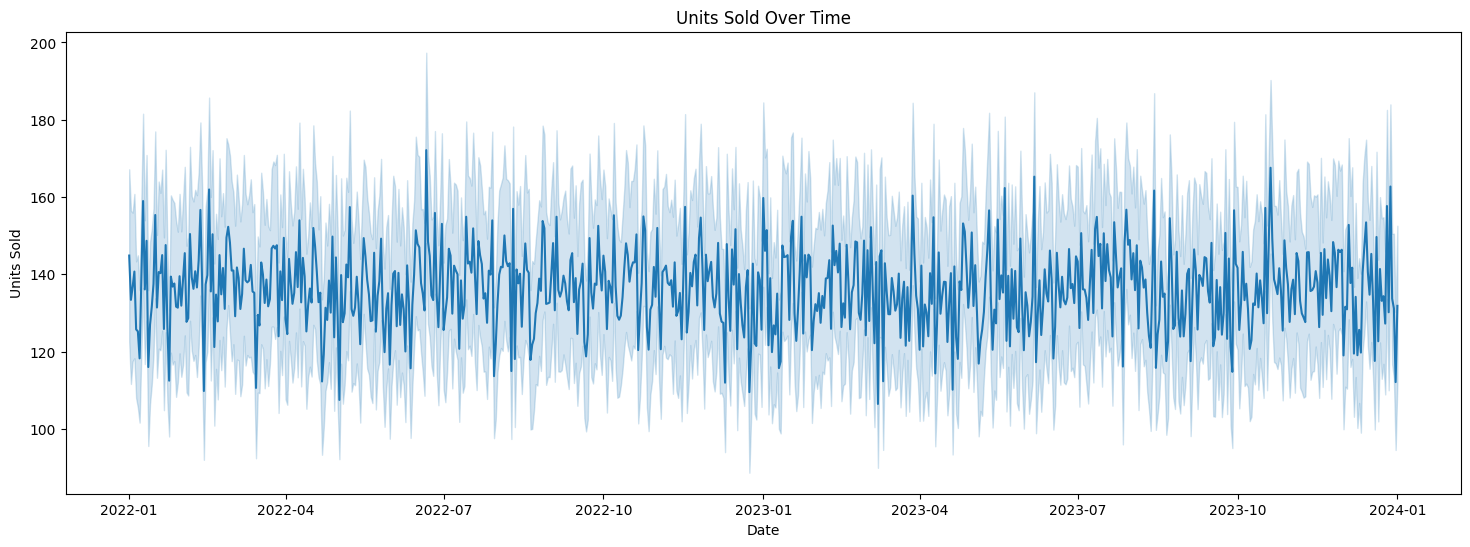

In [ ]:
plt.figure(figsize=(18, 6))
sns.lineplot(x='Date', y='Units Sold', data=df_capped)
plt.title('Units Sold Over Time')
plt.show()

In [ ]:
!pip install pmdarima
from pmdarima import auto_arima

# Automatically find optimal (p, d, q) for ARIMA
auto_arima_model = auto_arima(df_encoded["Units Sold"], seasonal=True, m=6, trace=True)
print(auto_arima_model.summary())

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[6] intercept   : AIC=4807.478, Time=273.31 sec


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


 ARIMA(0,0,0)(0,0,0)[6] intercept   : AIC=4800.513, Time=10.67 sec


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


 ARIMA(1,0,0)(1,0,0)[6] intercept   : AIC=4803.619, Time=72.79 sec


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


 ARIMA(0,0,1)(0,0,1)[6] intercept   : AIC=4803.623, Time=25.15 sec


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


 ARIMA(0,0,0)(0,0,0)[6]             : AIC=73526.592, Time=2.50 sec


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


 ARIMA(0,0,0)(1,0,0)[6] intercept   : AIC=4801.625, Time=41.41 sec


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


 ARIMA(0,0,0)(0,0,1)[6] intercept   : AIC=4801.629, Time=13.97 sec


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


 ARIMA(0,0,0)(1,0,1)[6] intercept   : AIC=4800.610, Time=238.68 sec


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


 ARIMA(1,0,0)(0,0,0)[6] intercept   : AIC=4802.507, Time=8.06 sec


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


 ARIMA(0,0,1)(0,0,0)[6] intercept   : AIC=4802.508, Time=12.29 sec


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


 ARIMA(1,0,1)(0,0,0)[6] intercept   : AIC=4804.507, Time=27.72 sec

Best model:  ARIMA(0,0,0)(0,0,0)[6] intercept
Total fit time: 726.952 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                73100
Model:                        SARIMAX   Log Likelihood               -2398.256
Date:                Sat, 22 Feb 2025   AIC                           4800.513
Time:                        20:12:20   BIC                           4818.912
Sample:                             0   HQIC                          4806.176
                              - 73100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3123      0.001    262.265      0.000       0.3

## 5. Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

def train_test_splitting(df, target_column):
    df = df.sort_values(by="Date")  # Ensure data is sorted by time

    # Separate features (X) and target (y)
    X = df.drop(columns=[target_column, "Date"])  # Drop target and Date
    y = df[target_column]

    # Split dataset (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    return X_train, X_test, y_train, y_test


## 6. Model Train


*   Hybrid_ARIMA_LSTM




 Training Hybrid ARIMA + LSTM Model...


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' wa

457/457 [==============================] - 1s 2ms/step

 Model: Hybrid_ARIMA_LSTM
Mean Absolute Error (MAE): 0.0179
Mean Squared Error (MSE): 0.0005
Root Mean Squared Error (RMSE): 0.0214
R² Score: 0.9926

 First 10 Actual vs Predicted Values:
         Actual  Predicted
58480  0.039261   0.041472
58481  0.646651   0.633262
58482  0.480370   0.502197
58483  0.062356   0.040741
58484  0.207852   0.178774
58485  0.762125   0.725304
58486  0.087760   0.085787
58487  0.025404   0.019213
58488  0.073903   0.057462
58489  0.080831   0.041051


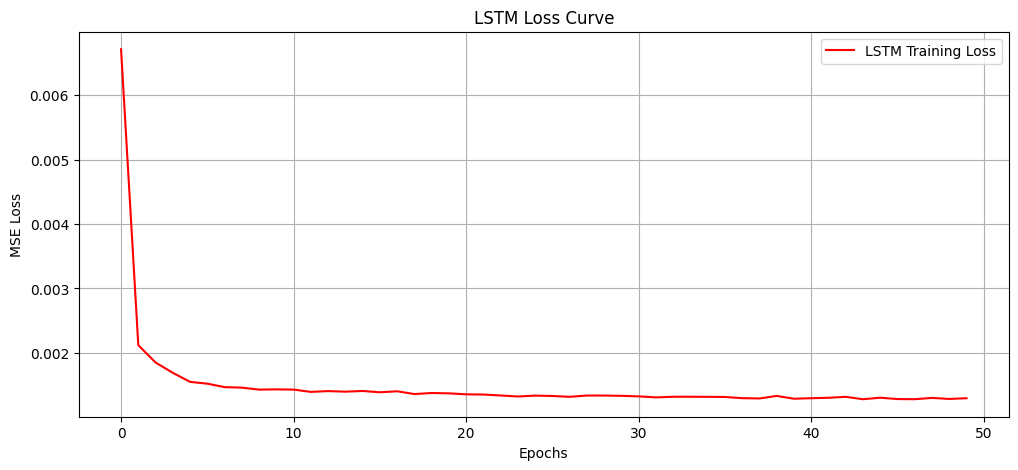

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Function to evaluate models
def evaluate_model(y_test, y_pred, model_name):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"\n Model: {model_name}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")

    # Print first 10 actual vs. predicted values
    results_df = pd.DataFrame({"Actual": y_test.values, "Predicted": y_pred})
    print("\n First 10 Actual vs Predicted Values:")
    print(results_df.head(10))

# Hybrid ARIMA + LSTM Training
def train_hybrid_arima_lstm(y_train, X_train, y_test, X_test):
    print("\n Training Hybrid ARIMA + LSTM Model...")

    # Step 1: Train ARIMA on y_train
    p, d, q = auto_arima(y_train, seasonal=False).order
    arima_model = ARIMA(y_train, order=(p, d, q)).fit()

    # ARIMA Predictions
    arima_pred_train = arima_model.fittedvalues
    arima_pred_test = arima_model.forecast(steps=len(y_test))

    # Step 2: Compute ARIMA residuals
    residuals_train = y_train - arima_pred_train

    # Step 3: Train LSTM on residuals
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Reshape for LSTM
    X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
    X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

    # Define LSTM model
    lstm_model = Sequential([
        LSTM(50, activation='relu', return_sequences=True, input_shape=(1, X_train.shape[1])),
        Dropout(0.2),
        LSTM(50, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])

    lstm_model.compile(optimizer='adam', loss='mse')

    # Train LSTM on residuals
    history = lstm_model.fit(X_train_lstm, residuals_train, epochs=50, batch_size=32, verbose=0)

    # Predict residuals using LSTM
    lstm_pred_test = lstm_model.predict(X_test_lstm).flatten()

    # Step 4: Combine ARIMA and LSTM predictions
    y_pred = arima_pred_test + lstm_pred_test

    # Evaluate model
    evaluate_model(y_test, y_pred, "Hybrid_ARIMA_LSTM")

    # Plot Loss Curve
    plt.figure(figsize=(12, 5))
    plt.plot(history.history['loss'], label="LSTM Training Loss", color='red')
    plt.xlabel("Epochs")
    plt.ylabel("MSE Loss")
    plt.title("LSTM Loss Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

    return (arima_model, lstm_model), y_pred
# Call train_test_splitting to create X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_splitting(df_encoded, 'Units Sold') # Assuming 'Units Sold' is your target column

# Call Hybrid Model Training
hybrid_model, hybrid_pred = train_hybrid_arima_lstm(y_train, X_train, y_test, X_test)

## 7. Hyperparameter Tuning

In [ ]:
###

## 8. X-AI

*   SHAP
*   LIME

In [ ]:
import lime
import lime.lime_tabular
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import shap

import xgboost as xgb
from lime import lime_tabular

**SHAP Count Plot**

In [ ]:
!pip install tensorflow==2.13.0
!pip install shap==0.42.1

In [ ]:
import numpy as np
import tensorflow as tf

# Reshape the background data for the explainer to match the LSTM input shape
# Select only numerical features for background data
numerical_features = X_train.select_dtypes(include=np.number).columns
background_data = X_train[numerical_features][:100].values.reshape(X_train[:100].shape[0], 1, len(numerical_features))

# Create an explainer using the DeepExplainer (for deep learning models)
explainer = shap.DeepExplainer(hybrid_model[1], background_data)

# Reshape the test data for SHAP value calculation, selecting only numerical features
X_test_reshaped = X_test[numerical_features].values.reshape(X_test.shape[0], 1, len(numerical_features))

# Compute SHAP values
shap_values = explainer.shap_values(X_test_reshaped)

# Reshape SHAP values to 2D if needed
shap_values = shap_values[0]  # Assuming only one output

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_test[numerical_features], plot_type="bar")  # Use numerical features for plotting



Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


StagingError: in user code:

    File "/usr/local/lib/python3.11/dist-packages/shap/explainers/_deep/deep_tf.py", line 259, in grad_graph  *
        x_grad = tape.gradient(out, shap_rAnD)

    LookupError: gradient registry has no entry for: shap_TensorListStack


**LIME Tabular Plot**

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    mode='regression'
)

# Choose a test sample to explain (Index 10 as an example)
sample_index = 10
exp = explainer.explain_instance(X_test.iloc[sample_index].values, hybrid_model.predict, num_features=5)

# Display the LIME Table Plot
exp.show_in_notebook(show_table=True)

AttributeError: 'tuple' object has no attribute 'predict'